# Sentiment Analysis for Parliamentary Speeches
## Simplified Implementation

This notebook analyzes sentiment in Slovak parliamentary speeches using multiple LLM families:

1. **OpenAI** models (e.g., GPT-5, GPT-5 Mini, GPT-5 Nano)
2. **Anthropic** models (e.g., Claude Sonnet, Claude Haiku)
3. **Google** models (e.g., Gemini 2.5 Flash, Gemini 2.0 Flash, Gemma instruction-tuned variants)
4. **Mistral** model (e.g,. magistral medium , magistral small )

---

## Methodology

### Institutional Prior
In parliamentary debate, it is **uncommon** for the *opposition* to speak **positively** about a bill submitted by the **government**. Typical sentiment in such contexts skews **neutral to negative**. While positive interventions do occur, they are **rare**.  

We therefore adopt the following empirical prior:

> **Prior assumption:** For speeches by opposition members concerning government-submitted bills, the prevalence of **positive** sentiment should be **low**.

### Evaluation Implication
Given this prior, a model that yields **excessively high rates of “positive” labels** in the above setting is likely **over-predicting positivity** (i.e., incurring false positives). Conversely, models that keep the **share of “positive” predictions low** (while still distinguishing neutral from negative) are **preferred** for this domain.

> **Heuristic criterion:** Among models applied to this subset of speeches, those with the **lowest proportion of positive labels** are considered better aligned with the expected distribution—*provided* they do not collapse into trivial “all negative” predictions (i.e., we also monitor class balance and calibration).

### Practical Notes
- We report **class distributions**, **per-class precision/recall/F1**, and **calibration plots** to ensure that “low positives” reflect **true discrimination** rather than **systematic bias** toward negative/neutral.
- Stratification by **role** (government vs. opposition), **bill origin** (government-submitted vs. other), and **time period** is used to confirm the stability of this prior.
- We manually review transcript segments that exhibit **inter-model disagreement** and assign **adjudicated (gold) sentiment labels**. Using these labels, we generate a **final comparative graph** that ranks models by their sentiment classification performance.

---





In [ ]:
import pandas as pd
import numpy as np
import os
import json
import re
from dotenv import load_dotenv
from typing import Literal
from pydantic import BaseModel
from mistralai import Mistral
from openai import OpenAI
from google import genai
import anthropic
import time
import tiktoken
from tqdm import tqdm
import random
import concurrent.futures
import threading
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
from utils.rate_limit import safe_apply_model, RateLimiter

In [2]:
df = pd.read_parquet(r'C:\Users\alexe\OneDrive\Desktop\Git\NLP\data\df_to_app_with_openAI_S_L_voyage_gdoogle_mistral_embeddings_navrh_zakona_obdobie_8_klub_check.parquet', engine='fastparquet')

In [4]:
ministries = [
    "Ministerstvo zdravotníctva SR",
    "Ministerstvo spravodlivosti SR",
    "Ministerstvo práce, sociálnych vecí a rodiny SR",
    "Ministerstvo vnútra SR",
    "Ministerstvo dopravy SR",
    "Ministerstvo hospodárstva SR",
    "Ministerstvo životného prostredia SR",
    "Ministerstvo kultúry SR",
    "Ministerstvo obrany SR",
    "Ministerstvo školstva, výskumu, vývoja a mládeže SR",
    "Ministerstvo pôdohospodárstva a rozvoja vidieka SR",
]

In [ ]:
opozicia = ['(-)', '(SMER - SD)','(ĽS Naše Slovensko)']
df_opozicia = df[df.klub.isin(opozicia)]
df_opozicia_ministri = df_opozicia[df_opozicia["Predkladateľ"].isin(ministries)]
koalicni_nezavisli = ['Antal, Marek', 'Budaj, Ján', 'Hattas, Marek', 'Klus, Martin','Kollár, Miroslav','Kozelová, Monika', 'Stančík, Andrej', 'Tabák, Romana','Valášek, Tomáš', 'Vaňová Jarmila','Čekovský, Kristián', 'Šeliga, Juraj',  'Šuteková, Miriam', 'Šíbl, Jaromír']

In [9]:
df_opozicia_ministri = df_opozicia_ministri[~df_opozicia_ministri["poslanec"].isin(koalicni_nezavisli)]

In [10]:
df_opozicia_ministri = df_opozicia_ministri[df_opozicia_ministri["druh_vystupenia"] == "Vystúpenie v rozprave"]

In [11]:
df_opozicia_ministri = df_opozicia_ministri[(df_opozicia_ministri.num_tokens_mistral > 1000) & (df_opozicia_ministri.num_tokens_mistral < 3000)]

In [13]:
df_100 = df_opozicia_ministri.sample(n=100, random_state=42)

In [14]:
load_dotenv(r"..\keys.env")

True

In [15]:
openai_api_key = os.getenv("OPENAI_API_KEY")
google_api_key = os.getenv("GOOGLE_API_KEY")
mistral_api_key = os.environ["MISTRAL_API_KEY"]
anthropic_api_key = os.getenv("ANTROPHIC_API_KEY")


# Initialize the clients
client = OpenAI(api_key=openai_api_key)
google_model = genai.Client(api_key=google_api_key)
antrophic_client = anthropic.Anthropic(api_key=anthropic_api_key)
mistrals = Mistral(api_key=mistral_api_key)

In [16]:
class Sentiment(BaseModel):
    sentiment: Literal["Pozitívny", "Neutrálny", "Negatívny"]


In [ ]:
MODELS = {
    # OpenAI Models
    "openai_5": {
        "type": "openai",
        "name": "gpt-5",
        "column": "sentiment_openai_5",
        "pydantic": True
    },
    "openai_5mini": {
        "type": "openai", 
        "name": "gpt-5-mini",
        "column": "sentiment_openai_5mini",
        "pydantic": True
    },
    "openai_5nano": {
        "type": "openai",
        "name": "gpt-5-nano", 
        "column": "sentiment_openai_5nano",
        "pydantic": True
    },
    
    # OpenAI Reasoning Models with different effort levels (using GPT-5 models)
    "openai_reasoning_minimal": {
        "type": "openai_reasoning",
        "name": "gpt-5",
        "column": "sentiment_openai_reasoning_minimal",
        "pydantic": True,
        "effort": "minimal"
    },
    "openai_reasoning_low": {
        "type": "openai_reasoning", 
        "name": "gpt-5",
        "column": "sentiment_openai_reasoning_low",
        "pydantic": True,
        "effort": "low"
    },
    "openai_reasoning_medium": {
        "type": "openai_reasoning",
        "name": "gpt-5",
        "column": "sentiment_openai_reasoning_medium", 
        "pydantic": True,
        "effort": "medium"
    },
    "openai_reasoning_high": {
        "type": "openai_reasoning",
        "name": "gpt-5",
        "column": "sentiment_openai_reasoning_high",
        "pydantic": True,
        "effort": "high"
    },
  

    "anthropic_opus": {
    "type": "anthropic",
    "name": "claude-opus-4-1-20250805",
    "column": "sentiment_anthropic_opus",
    "pydantic": False
},

    # Keep haiku but update if needed
    "anthropic_haiku": {
    "type": "anthropic",
    "name": "claude-3-5-haiku-20241022",
    "column": "sentiment_anthropic_haiku",
    "pydantic": False
},

    # Add Claude Sonnet 4 as a thinking model (simulated reasoning)
    "anthropic_sonnet_thinking": {
    "type": "anthropic_reasoning",
    "name": "claude-sonnet-4-20250514",
    "column": "sentiment_anthropic_sonnet_thinking",
    "pydantic": False,
    "effort": "medium"
    },



    # Google Models - Gemini 2.5 series with thinking capabilities
    "google_gemini_2_5_pro": {
        "type": "google",
        "name": "gemini-2.5-pro",
        "column": "sentiment_google_gemini_2_5_pro",
        "pydantic": True
    },
    "google_gemini_2_5_flash": {
        "type": "google",
        "name": "gemini-2.5-flash",
        "column": "sentiment_google_gemini_2_5_flash",
        "pydantic": True
    },
    "google_gemini_2_5_flash_lite": {
        "type": "google",
        "name": "gemini-2.5-flash-lite",
        "column": "sentiment_google_gemini_2_5_flash_lite",
        "pydantic": True
    },
    
    # Google Thinking Models with different thinking budgets
    "google_thinking_minimal": {
        "type": "google_reasoning",
        "name": "gemini-2.5-flash",
        "column": "sentiment_google_thinking_minimal",
        "pydantic": True,
        "effort": "minimal"
    },
    "google_thinking_medium": {
        "type": "google_reasoning",
        "name": "gemini-2.5-pro",
        "column": "sentiment_google_thinking_medium",
        "pydantic": True,
        "effort": "medium"
    },
    "google_thinking_high": {
        "type": "google_reasoning",
        "name": "gemini-2.5-pro", 
        "column": "sentiment_google_thinking_high",
        "pydantic": True,
        "effort": "high"
    },
    
    # Mistral Models (August 2025 versions)
    "mistral_medium_31": {
        "type": "mistral",
        "name": "mistral-medium-2508",
        "column": "sentiment_mistral_medium_31",
        "pydantic": True
    },
    "magistral_medium": {
        "type": "mistral", 
        "name": "magistral-medium-2507",
        "column": "sentiment_magistral_medium",
        "pydantic": True
    },
    "magistral_small": {
        "type": "mistral",
        "name": "magistral-small-2507",
        "column": "sentiment_magistral_small",
        "pydantic": True
    },
    
    # Gemma Instruction-Tuned Models  
    "gemma_3_27b_it": {
        "type": "gemma",
        "name": "gemma-3-27b-it",
        "column": "sentiment_gemma_3_27b_it", 
        "pydantic": False
    },
    "gemma_3_12b_it": {
        "type": "gemma",
        "name": "gemma-3-12b-it",
        "column": "sentiment_gemma_3_12b_it",
        "pydantic": False
    },
    "gemma_3_4b_it": {
        "type": "gemma",
        "name": "gemma-3-4b-it", 
        "column": "sentiment_gemma_3_4b_it",
        "pydantic": False
    },
    "gemma_3_1b_it": {
        "type": "gemma",
        "name": "gemma-3-1b-it",
        "column": "sentiment_gemma_3_1b_it",
        "pydantic": False
    }
}

In [ ]:
# Create limiters for different models
gemma_limiter = RateLimiter(rpm=30, rpd=14400)  # Gemma: 30 RPM, 14,400 RPD
mistral_limiter = RateLimiter(rps=6)            # Mistral: 6 RPS
openai_limiter = RateLimiter(rpm=3500)          # OpenAI: 3,500 RPM (adjust as needed)
anthropic_limiter = RateLimiter(rpm=240)        # Anthropic: 240 RPM (adjust as needed)

In [18]:
def extract_sentiment_from_json(model_response_text: str) -> str | None:
    """
    Safely parses a model's text response to extract a sentiment value from a JSON object.

    This function is designed to be robust against common LLM response variations,
    such as including markdown code blocks (` ```json ... ``` `) or extra explanatory text.

    Args:
        model_response_text: The raw string output from the language model.

    Returns:
        The sentiment string (e.g., "Pozitívny", "Neutrálny", "Negatívny") if found,
        otherwise None.
    """
    if not isinstance(model_response_text, str):
        print(f"Warning: Input was not a string, but {type(model_response_text)}. Cannot extract sentiment.")
        return None

    # Attempt to find a JSON object within the response text using a regex.
    # This is more robust than assuming the entire string is valid JSON.
    json_match = re.search(r'\{.*\}', model_response_text, re.DOTALL)
    if not json_match:
        print(f"Warning: No JSON object found in the model response: '{model_response_text}'")
        return None

    json_string = json_match.group(0)

    try:
        # Parse the extracted JSON string
        data = json.loads(json_string)
        
        # Check if the parsed data is a dictionary and contains the 'sentiment' key
        if isinstance(data, dict) and 'sentiment' in data:
            sentiment = data['sentiment']
            
            # Validate that the extracted sentiment is one of the expected string values
            if isinstance(sentiment, str) and sentiment in ["Pozitívny", "Neutrálny", "Negatívny"]:
                return sentiment
            else:
                print(f"Warning: 'sentiment' key found, but its value is not a valid sentiment string: '{sentiment}'")
                return None
        else:
            print(f"Warning: Parsed JSON does not contain a 'sentiment' key: '{json_string}'")
            return None

    except json.JSONDecodeError:
        print(f"Error: Failed to decode the extracted JSON string: '{json_string}'")
        return None


In [19]:
def build_prompt(text: str) -> str:
    return f"""Text je vystupením poslanca Národnej rady Slovenskej republiky ohľadom zákona, o ktorom sa diskutuje a bude sa aj hlasovať.
    Tvoja úloha je posúdiť, či je jeho vystúpenie pozitívne, negatívne alebo neutrálne voči predkladanému zákonu.
    Inštrukcie:\n 
    1. Prečítaj si jeho vystupenie.\n
    2. Rozhodni, či jeho vystúpenie je voči predkladanému zákonu pozitívne, alebo negatívne, či neutrálne :\n
    3. Na základe toho, ako hodnotíš jeho vystúpenie, vyber jednu z možností:\n
- "Pozitívny"  (Vystupenie podporuje zakon),\n
- "Neutrálny"  (Vystupenie je neutrálne voči zákonu),\n
- "Negatívny"  (Vystupenie nepodporuje zakon)\n


Vystúpenie poslanca:\n
{text}

."""

In [20]:
def build_prompt_gemna(text: str) -> str:
    return f"""Text je vystupením poslanca Národnej rady Slovenskej republiky ohľadom zákona, o ktorom sa disktuje a bude sa aj hlasovať.
    Tvoja úloha je posúdiť, či je jeho vystúpenie pozitívne, negatívne alebo neutrálne voči predkladanému zákonu.
    Inštrukcie:\n 
    1. Prečítaj si jeho vystupenie.\n
    2. Rozhodni, či jeho vystúpenie je voči predkladanému zákonu pozitívne, alebo negatívne, či neutrálne :\n
    3. Na základe toho, ako hodnotíš jeho vystúpenie, vyber jednu z možností:\n
- "Pozitívny"  (Vystupenie podporuje zakon),\n
- "Neutrálny"  (Vystupenie je neutrálne voči zákonu),\n
- "Negatívny"  (Vystupenie nepodporuje zakon)\n

Odpovedaj len jedným slovom, bez vysvetlenia.\n 

Vystúpenie poslanca:\n
{text}

"""

In [22]:
def analyze_sentiment(text, model_type, model_name=None, effort_level=None):
    """
    Unified sentiment analysis function that handles all model types.
    
    Parameters:
    - text: The text to analyze
    - model_type: One of "openai", "anthropic", "google", "mistral", "gemma", "openai_reasoning", "anthropic_reasoning", "google_reasoning"
    - model_name: Specific model name (if None, uses default for type)
    - effort_level: For reasoning models - "minimal", "low", "medium", "high"
    
    Returns:
    - Sentiment as string or Sentiment object depending on the model
    """
    # Apply rate limiting based on model type
    if model_type in ["openai", "openai_reasoning"]:
        openai_limiter.acquire()
    elif model_type in ["anthropic", "anthropic_reasoning"]:
        anthropic_limiter.acquire()
    elif model_type == "mistral":
        mistral_limiter.acquire()
    elif model_type in ["gemma", "google", "google_reasoning"]:
        gemma_limiter.acquire()
    
    # Use the appropriate prompt format
    if model_type == "gemma":
        prompt = build_prompt_gemna(text)
    else:
        prompt = build_prompt(text)
    
    # Process based on model type
    if model_type == "openai":
        model = model_name or "gpt-4o"
        completion = client.beta.chat.completions.parse(
            model=model,
            messages=[
                {"role": "system", "content": "Ste expert na analýzu sentimentu slovenských prejavov. Analyzujte a klasifikujte nasledujúci text do kategórií: Pozitívny (podpora), Neutrálny (neutrálny postoj), Negatívny (kritika). Odpovedajte len jednou z hodnôt: 'Pozitívny', 'Neutrálny' alebo 'Negatívny'."},
                {"role": "user", "content": prompt}
            ],
            response_format=Sentiment,
        )
        return completion.choices[0].message.parsed
    
    elif model_type == "openai_reasoning":
        model = model_name or "gpt-5"
        # Map effort levels to reasoning_effort parameter (GPT-5 supports this directly)
        effort_mapping = {
            "minimal": "minimal",
            "low": "low", 
            "medium": "medium",
            "high": "high"
        }
        reasoning_effort = effort_mapping.get(effort_level, "medium")
        
        completion = client.beta.chat.completions.parse(
            model=model,
            messages=[
                {"role": "user", "content": f"Ste expert na analýzu sentimentu slovenských prejavov. Analyzujte a klasifikujte nasledujúci text do kategórií: Pozitívny (podpora), Neutrálny (neutrálny postoj), Negatívny (kritika). Odpovedajte len jednou z hodnôt: 'Pozitívny', 'Neutrálny' alebo 'Negatívny'. Text: {prompt}"}
            ],
            response_format=Sentiment,
            reasoning_effort=reasoning_effort
        )
        return completion.choices[0].message.parsed
    
    elif model_type == "anthropic":
        model = model_name or "claude-sonnet-4-20250514"
        system_prompt = (
            "Ste expert na analýzu sentimentu slovenských prejavov. "
            "Prosím, poskytnite klasifikáciu sentimentu vo formáte JSON nasledovne:\n"
            '{"sentiment": "Pozitívny"}, {"sentiment": "Neutrálny"} alebo {"sentiment": "Negatívny"} .\n'
            "Odpovedajte len platným JSON, bez ďalšieho textu."
        )
        
        message = antrophic_client.messages.create(
            model=model,
            max_tokens=50,
            temperature=0,
            system=system_prompt,
            messages=[{"role": "user", "content": prompt}]
        )
        
        raw_response_text = message.content[0].text
        sentiment_value = extract_sentiment_from_json(raw_response_text)
        return sentiment_value
    
    elif model_type == "anthropic_reasoning":
        model = model_name or "claude-sonnet-4-20250514"
        # For Anthropic, we simulate reasoning effort through enhanced system prompts
        reasoning_prompts = {
            "minimal": "Rýchlo analyzujte sentiment tohto slovenského parlamentného prejavu:",
            "medium": "Dôkladne analyzujte sentiment tohto slovenského parlamentného prejavu, zvážte kontext a nuansy:",
            "high": "Veľmi dôkladne analyzujte sentiment tohto slovenského parlamentného prejavu s podrobným zvážením kontextu, nuáns a implikácií:"
        }
        reasoning_prompt = reasoning_prompts.get(effort_level, reasoning_prompts["medium"])
        
        system_prompt = (
            f"{reasoning_prompt} "
            "Ste expert na analýzu sentimentu slovenských prejavov. "
            "Prosím, poskytnite klasifikáciu sentimentu vo formáte JSON nasledovne:\n"
            '{"sentiment": "Pozitívny"}, {"sentiment": "Neutrálny"} alebo {"sentiment": "Negatívny"} .\n'
            "Odpovedajte len platným JSON, bez ďalšieho textu."
        )
        
        message = antrophic_client.messages.create(
            model=model,
            max_tokens=100,
            temperature=0,
            system=system_prompt,
            messages=[{"role": "user", "content": prompt}]
        )
        
        raw_response_text = message.content[0].text
        sentiment_value = extract_sentiment_from_json(raw_response_text)
        return sentiment_value

    elif model_type == "google":
        model = model_name or "gemini-2.5-flash"
        # Fix the contents format for Google Gemini API
        full_prompt = f"Analyzuj sentiment a odpovedz len hodnotu Pozitívny, Neutrálny alebo Negatívny v nasledujúcom formáte JSON: {{\"sentiment\": \"Pozitívny\"}}, {{\"sentiment\": \"Neutrálny\"}} alebo {{\"sentiment\": \"Negatívny\"}}.\n\n{prompt}"
        
        response = google_model.models.generate_content(
            model=model,
            contents=full_prompt,
            config={
                'response_mime_type': 'application/json',
                'response_schema': Sentiment,
            },
        )
        return response.parsed
    
    elif model_type == "google_reasoning":
        from google.genai import types
        
        model = model_name or "gemini-2.5-pro"
        
        # Map effort levels to thinking budgets
        thinking_budgets = {
            "minimal": 512,     # Low thinking budget for simple analysis
            "medium": 2048,     # Medium thinking budget for balanced analysis  
            "high": 8192        # High thinking budget for complex analysis
        }
        thinking_budget = thinking_budgets.get(effort_level, 2048)
        
        # Fix the contents format for Google Gemini API with thinking
        full_prompt = f"Analyzuj sentiment tohto slovenského parlamentného prejavu a odpovedz len hodnotu Pozitívny, Neutrálny alebo Negatívny v nasledujúcom formáte JSON: {{\"sentiment\": \"Pozitívny\"}}, {{\"sentiment\": \"Neutrálny\"}} alebo {{\"sentiment\": \"Negatívny\"}}.\n\nText: {prompt}"
        
        response = google_model.models.generate_content(
            model=model,
            contents=full_prompt,
            config=types.GenerateContentConfig(
                response_mime_type='application/json',
                response_schema=Sentiment,
                thinking_config=types.ThinkingConfig(
                    thinking_budget=thinking_budget,
                    include_thoughts=False  # We don't need thought summaries for this task
                )
            ),
        )
        return response.parsed
    
    elif model_type == "mistral":
        model = model_name or "mistral-medium-2508"
        response = mistrals.chat.parse(
            model=model,
            messages=[
                {"role": "system", "content": "Ste expert na analýzu sentimentu slovenských prejavov. Analyzujte a klasifikujte nasledujúci text do kategórií: Pozitívny (podpora), Neutrálny (neutrálny postoj), Negatívny (kritika). Odpovedajte len jednou z hodnôt: 'Pozitívny', 'Neutrálny' alebo 'Negatívny'."},
                {"role": "user", "content": prompt}
            ],
            response_format=Sentiment
        )
        return response.choices[0].message.parsed
    
    elif model_type == "gemma":
        model = model_name or "gemma-3-27b-it"
        response = google_model.models.generate_content(
            model=model,
            contents=prompt
        )
        return response.text.strip().lower()
    
    else:
        raise ValueError(f"Unknown model type: {model_type}")

In [23]:
def process_dataframe(df, model_key, max_workers=5, checkpoint=True):
    """
    Process the dataframe with the specified model in parallel.
    
    Parameters:
    - df: The dataframe to process
    - model_key: Key from the MODELS dictionary
    - max_workers: Number of parallel workers
    - checkpoint: Whether to save checkpoints
    """
    # Get model configuration
    if model_key not in MODELS:
        raise ValueError(f"Unknown model key: {model_key}")
    
    model_config = MODELS[model_key]
    col_name = model_config["column"]
    is_pydantic = model_config["pydantic"]
    effort_level = model_config.get("effort", None)  # Get effort level if available
    
    # Initialize column if it doesn't exist
    if col_name not in df.columns:
        df[col_name] = pd.NA
    
    # Select only rows that need processing (no filtering by speech type as df is already filtered)
    row_labels = df[df[col_name].isna()].index
    texts = df.loc[row_labels, "prepis"].values
    
    if len(texts) == 0:
        print(f"No rows to process for {model_key}")
        return df
    
    print(f"Processing {len(texts)} rows with {model_key}")
    
    # Create a function that calls the model with the right parameters
    def worker(text):
        return safe_apply_model(
            lambda t: analyze_sentiment(t, model_config["type"], model_config["name"], effort_level),
            text,
            is_pydantic=is_pydantic
        )
    
    # Process in parallel
    results = [None] * len(texts)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {ex.submit(worker, txt): pos for pos, txt in enumerate(texts)}
        for fut in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {model_key}"):
            pos = futures[fut]
            results[pos] = fut.result()
    
    # Update dataframe
    df.loc[row_labels, col_name] = results
    
    # Save checkpoint if requested
    if checkpoint:
        checkpoint_path = f"../data/checkpoint_{col_name}.parquet"
        df.to_parquet(checkpoint_path, engine="pyarrow", index=False)
        print(f"Checkpoint saved: {checkpoint_path}")
    
    return df

# =========================================================
# 6 · Process All Models or Specific Model Groups
# =========================================================

def process_model_group(df, group_keys, max_workers_per_model=None):
    """
    Process a group of models from the MODELS dictionary.
    
    Parameters:
    - df: The dataframe to process
    - group_keys: List of keys from MODELS to process
    - max_workers_per_model: Dictionary mapping model keys to max_workers
                            or a single int for all models
    """
    if max_workers_per_model is None:
        # Default settings for different model types (reduced for reasoning models)
        max_workers_per_model = {
            "openai_5": 5, "openai_5mini": 5, "openai_5nano": 5,
            "openai_reasoning_minimal": 2, "openai_reasoning_low": 2, "openai_reasoning_medium": 1, "openai_reasoning_high": 1,
            "anthropic_opus": 5, "anthropic_haiku": 5, "anthropic_sonnet_thinking": 2,
            "google_gemini_2_5_pro": 5, "google_gemini_2_5_flash": 5, "google_gemini_2_5_flash_lite": 5,
            "google_thinking_minimal": 2, "google_thinking_medium": 2, "google_thinking_high": 1,
            "mistral_medium_31": 6, "magistral_medium": 6, "magistral_small": 6,
            "gemma_3_27b_it": 2, "gemma_3_12b_it": 2, "gemma_3_4b_it": 2, "gemma_3_1b_it": 2, 
        }
    elif isinstance(max_workers_per_model, int):
        # Use the same value for all models
        max_workers_per_model = {key: max_workers_per_model for key in group_keys}
    
    for model_key in group_keys:
        if model_key not in MODELS:
            print(f"Warning: Unknown model key: {model_key}, skipping")
            continue
        
        max_workers = max_workers_per_model.get(model_key, 5)
        print(f"\nProcessing {model_key} with {max_workers} workers")
        
        df = process_dataframe(df, model_key, max_workers=max_workers)
        
    # Final save with all models processed
    final_path = f"../data/sentiment_analysis_results_{int(time.time())}.parquet"
    df.to_parquet(final_path, engine="pyarrow", index=False)
    print(f"Final results saved: {final_path}")
    
    return df

In [24]:


def run_single_model(dataframe, model_key):
    """
    Run a single model on the dataframe or a sample of it
    
    Parameters:
    - dataframe: DataFrame containing the speeches
    - model_key: Key from the MODELS dictionary
   
    
    Returns:
    - Updated dataframe with sentiment analysis results
    """

    
    model_config = MODELS[model_key]
    column_name = model_config["column"]
    
    print(f"Running {model_key} ({model_config['name']}) on {len(dataframe)} rows")
    result_df = process_dataframe(
        dataframe, 
        model_key, 
        max_workers=5,  # Adjust based on your needs
        checkpoint=True
    )
    
    # Print some statistics
    if column_name in result_df.columns:
        non_null = result_df[column_name].notna().sum()
        print(f"Completed {non_null} out of {len(dataframe)} rows ({non_null/len(dataframe)*100:.1f}%)")
        
        if non_null > 0:
            sentiment_counts = result_df[column_name].value_counts(normalize=True) * 100
            print(f"Sentiment distribution:")
            for sentiment, percentage in sentiment_counts.items():
                print(f"  - {sentiment}: {percentage:.1f}%")
    
    return result_df




In [28]:
# =========================================================
# RUN ALL MODELS ON DF_100 (SIMPLIFIED APPROACH)
# =========================================================

# Define thinking and non-thinking models
thinking_models = [
    "openai_reasoning_minimal", "openai_reasoning_low", "openai_reasoning_medium", "openai_reasoning_high",
    "google_thinking_minimal", "google_thinking_medium", "google_thinking_high",
    "anthropic_sonnet_thinking"
]

non_thinking_models = [
    "openai_5", "openai_5mini", "openai_5nano",
    "anthropic_opus", "anthropic_haiku",
    "google_gemini_2_5_pro", "google_gemini_2_5_flash", "google_gemini_2_5_flash_lite",
    "mistral_medium_31", "magistral_medium", "magistral_small",
    "gemma_3_27b_it", "gemma_3_12b_it", "gemma_3_4b_it", "gemma_3_1b_it"
]

# Combine all models
all_models = thinking_models + non_thinking_models

print(f"🎯 Running {len(all_models)} models on df_100 ({len(df_100)} samples)")
print(f"📊 Thinking models: {len(thinking_models)}")
print(f"📊 Non-thinking models: {len(non_thinking_models)}")

# Work with a copy of df_100
df_results = df_100.copy()

# Track results
successful_models = []
failed_models = []

print(f"\n� Starting processing...")
print("="*80)

🎯 Running 23 models on df_100 (100 samples)
📊 Thinking models: 8
📊 Non-thinking models: 15

� Starting processing...


In [ ]:
# =========================================================
# EXECUTE ALL MODELS
# =========================================================

for i, model_key in enumerate(all_models, 1):
    print(f"\n{'='*60}")
    print(f"MODEL {i}/{len(all_models)}: {model_key}")
    print(f"{'='*60}")
    
    try:
        if model_key not in MODELS:
            print(f"❌ {model_key}: NOT FOUND in MODELS dictionary")
            failed_models.append(model_key)
            continue
            
        model_config = MODELS[model_key]
        model_name = model_config['name']
        column_name = model_config['column']
        
        print(f"Model: {model_name}")
        print(f"Column: {column_name}")
        
        # Process the model
        df_results = process_dataframe(
            df_results, 
            model_key, 
            max_workers=2,  # Conservative to avoid rate limits
            checkpoint=True
        )
        
        # Check success
        if column_name in df_results.columns:
            valid_count = df_results[column_name].notna().sum()
            if valid_count > 0:
                successful_models.append(model_key)
                sentiment_dist = df_results[column_name].value_counts(normalize=True) * 100
                print(f"✅ SUCCESS: {valid_count}/{len(df_results)} valid results ({valid_count/len(df_results)*100:.1f}%)")
                for sentiment, percentage in sentiment_dist.items():
                    print(f"  - {sentiment}: {percentage:.1f}%")
            else:
                failed_models.append(model_key)
                print(f"❌ FAILED: No valid results")
        else:
            failed_models.append(model_key)
            print(f"❌ FAILED: Column not created")
            
    except Exception as e:
        failed_models.append(model_key)
        print(f"❌ FAILED: {str(e)}")

print(f"\n{'='*80}")
print(f"FINAL SUMMARY")
print(f"{'='*80}")
print(f"✅ Successful: {len(successful_models)}/{len(all_models)} models")
print(f"❌ Failed: {len(failed_models)}/{len(all_models)} models")

if successful_models:
    print(f"\n✅ Successful models:")
    for model in successful_models:
        column_name = MODELS[model]['column']
        valid_count = df_results[column_name].notna().sum()
        print(f"   - {model}: {valid_count} results")

if failed_models:
    print(f"\n❌ Failed models:")
    for model in failed_models:
        print(f"   - {model}")

# Show all sentiment columns created
sentiment_columns = [col for col in df_results.columns if col.startswith('sentiment_')]
print(f"\n📊 Created {len(sentiment_columns)} sentiment columns in df_results")
print(f"📊 Final dataframe shape: {df_results.shape}")

In [ ]:
# =========================================================
# SAVE RESULTS
# =========================================================

# Save the final results
timestamp = int(time.time())
final_file = f"../data/df_100_all_models_results_{timestamp}.parquet"
df_results.to_parquet(final_file, engine="pyarrow", index=False)
print(f"💾 Results saved to: {final_file}")

# Save as Excel for easy viewing
excel_file = f"../data/df_100_all_models_results_{timestamp}.xlsx"
df_results.to_excel(excel_file, index=False)
print(f"💾 Excel saved to: {excel_file}")

print(f"\n🎯 PROCESSING COMPLETE!")
print(f"📊 df_results contains all sentiment columns from successful models")
print(f"📊 Use df_results for further analysis")

# 🔄 Rerun Failed Models
## Identifying and Reprocessing None Sentiment Values

This section identifies models that failed to generate sentiment predictions (returned None) and reruns them to complete the analysis.

In [32]:
# =========================================================
# 🔍 IDENTIFY FAILED MODELS WITH NONE VALUES
# =========================================================

print("🔍 ANALYZING FAILED SENTIMENT PREDICTIONS")
print("=" * 60)

# Get all sentiment columns from df_results
sentiment_columns = [col for col in df_results.columns if col.startswith('sentiment_')]
print(f"📊 Found {len(sentiment_columns)} sentiment columns")

# Analyze None/null values for each model
failed_analysis = {}
models_to_rerun = []

for col in sentiment_columns:
    if col in df_results.columns:
        total_rows = len(df_results)
        none_count = df_results[col].isna().sum()
        none_percentage = (none_count / total_rows) * 100
        
        failed_analysis[col] = {
            'total_rows': total_rows,
            'none_count': none_count,
            'none_percentage': none_percentage,
            'successful_count': total_rows - none_count
        }
        
        if none_count > 0:
            # Find the model key that corresponds to this column
            model_key = None
            for key, config in MODELS.items():
                if config['column'] == col:
                    model_key = key
                    break
            
            if model_key:
                models_to_rerun.append(model_key)
                
        print(f"📈 {col}:")
        print(f"   ✅ Successful: {total_rows - none_count}/{total_rows} ({100-none_percentage:.1f}%)")
        print(f"   ❌ Failed (None): {none_count}/{total_rows} ({none_percentage:.1f}%)")

print(f"\n🚨 MODELS THAT NEED RERUNNING: {len(models_to_rerun)}")
for model in models_to_rerun:
    model_config = MODELS.get(model, {})
    print(f"   • {model} → {model_config.get('column', 'Unknown column')}")

if not models_to_rerun:
    print("✅ NO FAILED MODELS - All sentiment predictions completed successfully!")
else:
    print(f"\n📋 Summary: {len(models_to_rerun)} models need reprocessing")

🔍 ANALYZING FAILED SENTIMENT PREDICTIONS
📊 Found 23 sentiment columns
📈 sentiment_openai_reasoning_minimal:
   ✅ Successful: 100/100 (100.0%)
   ❌ Failed (None): 0/100 (0.0%)
📈 sentiment_openai_reasoning_low:
   ✅ Successful: 100/100 (100.0%)
   ❌ Failed (None): 0/100 (0.0%)
📈 sentiment_openai_reasoning_medium:
   ✅ Successful: 100/100 (100.0%)
   ❌ Failed (None): 0/100 (0.0%)
📈 sentiment_openai_reasoning_high:
   ✅ Successful: 100/100 (100.0%)
   ❌ Failed (None): 0/100 (0.0%)
📈 sentiment_google_thinking_minimal:
   ✅ Successful: 100/100 (100.0%)
   ❌ Failed (None): 0/100 (0.0%)
📈 sentiment_google_thinking_medium:
   ✅ Successful: 100/100 (100.0%)
   ❌ Failed (None): 0/100 (0.0%)
📈 sentiment_google_thinking_high:
   ✅ Successful: 100/100 (100.0%)
   ❌ Failed (None): 0/100 (0.0%)
📈 sentiment_anthropic_sonnet_thinking:
   ✅ Successful: 100/100 (100.0%)
   ❌ Failed (None): 0/100 (0.0%)
📈 sentiment_openai_5:
   ✅ Successful: 100/100 (100.0%)
   ❌ Failed (None): 0/100 (0.0%)
📈 sentiment_ope

In [33]:
# =========================================================
# 🔄 RERUN FAILED MODELS WITH ENHANCED ERROR HANDLING
# =========================================================

if models_to_rerun:
    print("🔄 STARTING RERUN OF FAILED MODELS")
    print("=" * 50)
    
    # Enhanced retry function with better error handling
    def enhanced_retry_model(df, model_key, max_retries=3):
        """
        Enhanced retry function for failed sentiment analysis models
        """
        model_config = MODELS[model_key]
        column_name = model_config['column']
        
        print(f"\n🔄 Rerunning: {model_key}")
        print(f"   Column: {column_name}")
        print(f"   Model: {model_config['name']}")
        
        # Find rows that need reprocessing (None values)
        none_mask = df[column_name].isna()
        rows_to_process = none_mask.sum()
        
        if rows_to_process == 0:
            print(f"   ✅ No None values found - skipping")
            return df, True
            
        print(f"   📊 Processing {rows_to_process} failed rows")
        
        # Process only the failed rows
        failed_indices = df[none_mask].index
        
        success_count = 0
        retry_count = 0
        
        for idx in failed_indices:
            text = df.loc[idx, 'prepis']
            
            for attempt in range(max_retries):
                try:
                    print(f"   🔄 Processing row {idx}, attempt {attempt + 1}/{max_retries}")
                    
                    # Use the same processing logic as before
                    result = safe_apply_model(
                        lambda t: analyze_sentiment(
                            t, 
                            model_config["type"], 
                            model_config["name"], 
                            model_config.get("effort", None)
                        ),
                        text,
                        is_pydantic=model_config["pydantic"],
                        retries=2  # Reduced retries per call since we're already retrying
                    )
                    
                    if result is not None:
                        df.loc[idx, column_name] = result
                        success_count += 1
                        print(f"   ✅ Row {idx} completed: {result}")
                        break  # Success, move to next row
                    else:
                        print(f"   ⚠️  Row {idx} attempt {attempt + 1} returned None")
                        
                except Exception as e:
                    print(f"   ❌ Row {idx} attempt {attempt + 1} failed: {str(e)}")
                    retry_count += 1
                    
                # Wait between retries to avoid rate limiting
                if attempt < max_retries - 1:
                    time.sleep(2)
        
        success_rate = (success_count / rows_to_process) * 100
        print(f"   📊 Rerun Results: {success_count}/{rows_to_process} successful ({success_rate:.1f}%)")
        
        # Save checkpoint after each model
        checkpoint_path = f"../data/checkpoint_rerun_{column_name}.parquet"
        df.to_parquet(checkpoint_path, engine="pyarrow", index=False)
        print(f"   💾 Checkpoint saved: {checkpoint_path}")
        
        return df, success_count > 0
    
    # Rerun each failed model
    rerun_results = {}
    
    for model_key in models_to_rerun:
        try:
            df_results, success = enhanced_retry_model(df_results, model_key)
            rerun_results[model_key] = 'SUCCESS' if success else 'PARTIAL/FAILED'
            
            # Small delay between models to avoid overwhelming APIs
            time.sleep(5)
            
        except Exception as e:
            print(f"❌ CRITICAL ERROR rerunning {model_key}: {str(e)}")
            rerun_results[model_key] = f'CRITICAL_ERROR: {str(e)}'
    
    print(f"\n🏁 RERUN COMPLETION SUMMARY")
    print("=" * 40)
    for model_key, result in rerun_results.items():
        status_emoji = "✅" if result == 'SUCCESS' else "⚠️" if 'PARTIAL' in result else "❌"
        print(f"{status_emoji} {model_key}: {result}")

else:
    print("✅ No models need rerunning - all sentiment analyses completed successfully!")

🔄 STARTING RERUN OF FAILED MODELS

🔄 Rerunning: gemma_3_27b_it
   Column: sentiment_gemma_3_27b_it
   Model: gemma-3-27b-it
   📊 Processing 3 failed rows
   🔄 Processing row 19735, attempt 1/3
   ✅ Row 19735 completed: negatívny
   🔄 Processing row 20044, attempt 1/3
   ✅ Row 19735 completed: negatívny
   🔄 Processing row 20044, attempt 1/3
   ✅ Row 20044 completed: negatívny
   🔄 Processing row 11412, attempt 1/3
   ✅ Row 20044 completed: negatívny
   🔄 Processing row 11412, attempt 1/3
   ✅ Row 11412 completed: pozitívny
   📊 Rerun Results: 3/3 successful (100.0%)
   ✅ Row 11412 completed: pozitívny
   📊 Rerun Results: 3/3 successful (100.0%)
   💾 Checkpoint saved: ../data/checkpoint_rerun_sentiment_gemma_3_27b_it.parquet
   💾 Checkpoint saved: ../data/checkpoint_rerun_sentiment_gemma_3_27b_it.parquet

🔄 Rerunning: gemma_3_12b_it
   Column: sentiment_gemma_3_12b_it
   Model: gemma-3-12b-it
   📊 Processing 2 failed rows
   🔄 Processing row 20044, attempt 1/3

🔄 Rerunning: gemma_3_12b_

In [ ]:
df_results.to_parquet(r"..\data\sentiment_analysis_results.parquet", engine="pyarrow", index=False  )

In [36]:
# Select sentiment columns
sentiment_columns = [col for col in df_results.columns if col.startswith('sentiment_') and col != 'sentiment_gemma_3_1b_it' and col != 'sentiment_gemma_3_4b_it' and col != 'sentiment_gemma_3_12b_it' and col != 'sentiment_gemma_3_27b_it' and col != 'sentiment_anthropic_haiku' and col != 'sentiment_openai_5nano']

In [37]:
def get_label(row):
    sentiments = row[sentiment_columns].dropna().unique()
    if len(sentiments) == 1:
        return sentiments[0]
    else:
        return "manual"

df_results['label'] = df_results.apply(get_label, axis=1)

In [38]:
df_results.to_excel("../data/disagreement_for_manual_labeling.xlsx", index=False)

In [40]:
df_results = pd.read_excel(r"C:\Users\alexe\OneDrive\Desktop\Git\NLP\data\disagreement_for_manual_labeling.xlsx")

In [50]:
df_results.sentiment_gemma_3_4b_it.value_counts()

sentiment_gemma_3_4b_it
negatívny    91
pozitívny     5
neutrálny     4
Name: count, dtype: int64

In [43]:
gemma_columns = ['sentiment_gemma_3_27b_it', 'sentiment_gemma_3_12b_it',
       'sentiment_gemma_3_4b_it', 'sentiment_gemma_3_1b_it']

for col in gemma_columns:
    print(f"{col}: {df_results[col].unique()}" )

sentiment_gemma_3_27b_it: ['negatívny' 'pozitívny' 'neutrálny']
sentiment_gemma_3_12b_it: ['negatívny' 'pozitívny' 'neutrálny']
sentiment_gemma_3_4b_it: ['negatívny' 'neutrálny' 'pozitívny']
sentiment_gemma_3_1b_it: ['neutrálny' '- "pozitívny"' 'pozitívny' 'negatívny'
 '- "pozitívny"\n- "neutrálny"\n- "negatívny"' 'negatívny.'
 '- neutrálny\n- neutrálny\n- negatívny' 'negativní.' 'negativní'
 '- pozitívny' '- "negatívny"' '- 1\n- 3' '- "neutrálny"' 'negativ'
 '- pozitívny\n- neutrálny\n- negatívny'
 '- "zbytočné"\n- "záujmy vlády slovenskej republiky"\n- "občania slovenskej republiky"']


# 📊 Sentiment Analysis Visualization
## Models Ranked by Negative Sentiment Percentage

This section creates visualizations showing which models identify the most negative sentiment in Slovak parliamentary speeches, with stacked bar charts displaying the full sentiment distribution.

In [ ]:

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

print("📊 Visualization libraries imported successfully!")
print(f"📅 Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📊 Visualization libraries imported successfully!
📅 Generated on: 2025-09-06 17:22:23


In [45]:
# =========================================================
# 📈 PREPARE SENTIMENT DATA FOR VISUALIZATION
# =========================================================

print("📈 PREPARING SENTIMENT ANALYSIS DATA")
print("=" * 50)

# Get all sentiment columns that have data
sentiment_columns = [col for col in df_results.columns if col.startswith('sentiment_')]
print(f"📊 Found {len(sentiment_columns)} sentiment columns")

# Calculate sentiment percentages for each model
model_sentiment_data = []

for col in sentiment_columns:
    # Skip columns with all null values
    if df_results[col].isna().all():
        print(f"⚠️  Skipping {col} - all values are null")
        continue
    
    # Get non-null values for this column
    valid_data = df_results[col].dropna()
    
    if len(valid_data) == 0:
        print(f"⚠️  Skipping {col} - no valid data")
        continue
    
    # Calculate sentiment percentages
    sentiment_counts = valid_data.value_counts()
    total_valid = len(valid_data)
    
    # Get model name for display (remove 'sentiment_' prefix)
    model_name = col.replace('sentiment_', '').replace('_', ' ').title()
    
    # Calculate percentages
    negative_pct = (sentiment_counts.get('Negatívny', 0) / total_valid) * 100
    neutral_pct = (sentiment_counts.get('Neutrálny', 0) / total_valid) * 100
    positive_pct = (sentiment_counts.get('Pozitívny', 0) / total_valid) * 100
    
    model_sentiment_data.append({
        'model': model_name,
        'column': col,
        'negative_pct': negative_pct,
        'neutral_pct': neutral_pct,
        'positive_pct': positive_pct,
        'total_valid': total_valid,
        'negative_count': sentiment_counts.get('Negatívny', 0),
        'neutral_count': sentiment_counts.get('Neutrálny', 0),
        'positive_count': sentiment_counts.get('Pozitívny', 0)
    })
    
    print(f"✅ {model_name}:")
    print(f"   📊 Valid samples: {total_valid}")
    print(f"   🔴 Negative: {negative_pct:.1f}% ({sentiment_counts.get('Negatívny', 0)})")
    print(f"   🟡 Neutral: {neutral_pct:.1f}% ({sentiment_counts.get('Neutrálny', 0)})")
    print(f"   🟢 Positive: {positive_pct:.1f}% ({sentiment_counts.get('Pozitívny', 0)})")

# Convert to DataFrame and sort by negative percentage (descending)
sentiment_df = pd.DataFrame(model_sentiment_data)
sentiment_df = sentiment_df.sort_values('negative_pct', ascending=False)

print(f"\n📊 SUMMARY:")
print(f"   ✅ Successfully processed: {len(sentiment_df)} models")
print(f"   📈 Sorted by negative sentiment percentage (highest first)")
print(f"   📊 Top 3 most negative models:")

for i, row in sentiment_df.head(3).iterrows():
    print(f"      {i+1}. {row['model']}: {row['negative_pct']:.1f}% negative")

# Display the prepared data
print(f"\n📋 PREPARED SENTIMENT DATA:")
print(sentiment_df[['model', 'negative_pct', 'neutral_pct', 'positive_pct', 'total_valid']].round(1))

📈 PREPARING SENTIMENT ANALYSIS DATA
📊 Found 23 sentiment columns
✅ Openai Reasoning Minimal:
   📊 Valid samples: 100
   🔴 Negative: 70.0% (70)
   🟡 Neutral: 9.0% (9)
   🟢 Positive: 21.0% (21)
✅ Openai Reasoning Low:
   📊 Valid samples: 100
   🔴 Negative: 70.0% (70)
   🟡 Neutral: 6.0% (6)
   🟢 Positive: 24.0% (24)
✅ Openai Reasoning Medium:
   📊 Valid samples: 100
   🔴 Negative: 70.0% (70)
   🟡 Neutral: 5.0% (5)
   🟢 Positive: 25.0% (25)
✅ Openai Reasoning High:
   📊 Valid samples: 100
   🔴 Negative: 70.0% (70)
   🟡 Neutral: 5.0% (5)
   🟢 Positive: 25.0% (25)
✅ Google Thinking Minimal:
   📊 Valid samples: 100
   🔴 Negative: 72.0% (72)
   🟡 Neutral: 6.0% (6)
   🟢 Positive: 22.0% (22)
✅ Google Thinking Medium:
   📊 Valid samples: 100
   🔴 Negative: 76.0% (76)
   🟡 Neutral: 4.0% (4)
   🟢 Positive: 20.0% (20)
✅ Google Thinking High:
   📊 Valid samples: 100
   🔴 Negative: 77.0% (77)
   🟡 Neutral: 4.0% (4)
   🟢 Positive: 19.0% (19)
✅ Anthropic Sonnet Thinking:
   📊 Valid samples: 100
   🔴 Neg

In [ ]:
# =========================================================
# 📋 CLASSIC METRIC: ACCURACY BY MODEL
# =========================================================

print("📋 DETAILED RANKING: MODELS BY ACCURACY")
print("=" * 70)

ranking_data = []
for col in sentiment_columns:
    if col not in df_results.columns:
        continue
    # Only consider rows with non-null label and prediction
    valid_mask = df_results[col].notna() & df_results['label'].notna()
    valid = df_results[valid_mask]
    if len(valid) == 0:
        continue
    # Accuracy: prediction matches label
    accuracy = (valid[col] == valid['label']).mean() * 100
    model_name = col.replace('sentiment_', '').replace('_', ' ').title()
    ranking_data.append({
        'Rank': len(ranking_data) + 1,
        'Model': model_name,
        'Accuracy %': f"{accuracy:.1f}%",
        'Valid Samples': len(valid)
    })

ranking_df = pd.DataFrame(ranking_data).sort_values('Accuracy %', ascending=False)

print("🏆 COMPLETE RANKING (Accuracy):")
print(ranking_df.to_string(index=False))

# Key statistics
print(f"\n📊 KEY STATISTICS:")
print(f"   🔢 Total models analyzed: {len(ranking_df)}")
print(f"   📈 Average accuracy: {ranking_df['Accuracy %'].str.rstrip('%').astype(float).mean():.1f}%")
print(f"   📊 Median accuracy: {ranking_df['Accuracy %'].str.rstrip('%').astype(float).median():.1f}%")
print(f"   📉 Min accuracy: {ranking_df['Accuracy %'].str.rstrip('%').astype(float).min():.1f}%")
print(f"   📈 Max accuracy: {ranking_df['Accuracy %'].str.rstrip('%').astype(float).max():.1f}%")

# Top and Bottom 5
print(f"\n🔝 TOP 5 MOST ACCURATE MODELS:")
for i, row in ranking_df.head(5).iterrows():
    print(f"   {i+1}. {row['Model']}: {row['Accuracy %']} ({row['Valid Samples']} samples)")

print(f"\n🔽 BOTTOM 5 LEAST ACCURATE MODELS:")
for i, row in ranking_df.tail(5).iterrows():
    print(f"   {len(ranking_df)-4+list(ranking_df.tail(5).index).index(i)}. {row['Model']}: {row['Accuracy %']} ({row['Valid Samples']} samples)")

# Save the ranking data
ranking_df.to_csv(f"../data/sentiment_accuracy_ranking_{timestamp}.csv", index=False)
ranking_df.to_excel(f"../data/sentiment_accuracy_ranking_{timestamp}.xlsx", index=False)

print(f"\n💾 ACCURACY RANKING DATA SAVED:")
print(f"   📄 CSV: ../data/sentiment_accuracy_ranking_{timestamp}.csv")
print(f"   📄 Excel: ../data/sentiment_accuracy_ranking_{timestamp}.xlsx")

# 🔧 Gemma Models Sentiment Normalization
## Cleaning and Standardizing Gemma Model Outputs

The Gemma models (especially gemma_3_1b_it) return inconsistent formats that need to be normalized to match the standard sentiment categories.

In [51]:
# =========================================================
# 🔧 GEMMA SENTIMENT NORMALIZATION FUNCTION
# =========================================================

def normalize_gemma_sentiment(sentiment_value):
    """
    Normalize Gemma model sentiment outputs to standard format.
    
    Maps various formats to: 'Pozitívny', 'Neutrálny', 'Negatívny', or 'Nespoľahlivé'
    """
    if pd.isna(sentiment_value) or sentiment_value is None:
        return None
    
    # Convert to string and normalize
    value = str(sentiment_value).lower().strip()
    
    # Define mapping dictionary for normalization
    sentiment_mapping = {
        # Standard formats (correctly formatted)
        'pozitívny': 'Pozitívny',
        'neutrálny': 'Neutrálny', 
        'negatívny': 'Negatívny',
        
        # Alternative spellings/formats
        'pozitivny': 'Pozitívny',
        'neutralny': 'Neutrálny',
        'negativny': 'Negatívny',
        
        # Czech variants (some models mix languages)
        'pozitivní': 'Pozitívny',
        'neutrální': 'Neutrálny',
        'negativní': 'Negatívny',
        
        # Shortened forms
        'pozit': 'Pozitívny',
        'neutr': 'Neutrálny',
        'negat': 'Negatívny',
        'negativ': 'Negatívny',
        
        # With punctuation
        'negatívny.': 'Negatívny',
        'pozitívny.': 'Pozitívny',
        'neutrálny.': 'Neutrálny',
        'negativní.': 'Negatívny',
    }
    
    # Direct mapping check
    if value in sentiment_mapping:
        return sentiment_mapping[value]
    
    # Check if value contains sentiment keywords
    for key, mapped_value in sentiment_mapping.items():
        if key in value:
            # If it's a simple case like "- pozitívny" or "pozitívny", extract it
            if (value.startswith('- ') and key in value) or (value.startswith('"') and key in value):
                return mapped_value
    
    # Special handling for complex multi-line responses
    if '\n' in value:
        # Split by lines and try to find a valid sentiment
        lines = value.split('\n')
        for line in lines:
            line_clean = line.strip().lower()
            # Remove leading dashes and quotes
            line_clean = line_clean.lstrip('- "').rstrip('"')
            if line_clean in sentiment_mapping:
                return sentiment_mapping[line_clean]
    
    # Handle cases with quotes and dashes
    cleaned_value = value.replace('"', '').replace('-', '').strip()
    if cleaned_value in sentiment_mapping:
        return sentiment_mapping[cleaned_value]
    
    # If none of the above work, mark as unreliable
    return 'Nespoľahlivé'

# =========================================================
# 📊 ANALYZE CURRENT GEMMA COLUMNS
# =========================================================

print("🔍 ANALYZING GEMMA SENTIMENT COLUMNS")
print("=" * 50)

# Identify Gemma columns
gemma_columns = [col for col in df_results.columns if 'gemma' in col.lower() and col.startswith('sentiment_')]
print(f"📊 Found {len(gemma_columns)} Gemma sentiment columns:")

for col in gemma_columns:
    print(f"\n📈 {col}:")
    unique_values = df_results[col].dropna().unique()
    print(f"   🔢 Unique values: {len(unique_values)}")
    print(f"   📋 Values: {unique_values[:10]}...")  # Show first 10 values
    if len(unique_values) > 10:
        print(f"   ⚠️  (Showing first 10 of {len(unique_values)} total values)")

print(f"\n🎯 NORMALIZATION PREVIEW:")
print("Sample of what will be normalized:")

# Show some examples of normalization
for col in gemma_columns:
    sample_values = df_results[col].dropna().unique()[:5]
    print(f"\n🔄 {col}:")
    for val in sample_values:
        normalized = normalize_gemma_sentiment(val)
        print(f"   '{val}' → '{normalized}'")

🔍 ANALYZING GEMMA SENTIMENT COLUMNS
📊 Found 4 Gemma sentiment columns:

📈 sentiment_gemma_3_27b_it:
   🔢 Unique values: 3
   📋 Values: ['negatívny' 'pozitívny' 'neutrálny']...

📈 sentiment_gemma_3_12b_it:
   🔢 Unique values: 3
   📋 Values: ['negatívny' 'pozitívny' 'neutrálny']...

📈 sentiment_gemma_3_4b_it:
   🔢 Unique values: 3
   📋 Values: ['negatívny' 'neutrálny' 'pozitívny']...

📈 sentiment_gemma_3_1b_it:
   🔢 Unique values: 16
   📋 Values: ['neutrálny' '- "pozitívny"' 'pozitívny' 'negatívny'
 '- "pozitívny"\n- "neutrálny"\n- "negatívny"' 'negatívny.'
 '- neutrálny\n- neutrálny\n- negatívny' 'negativní.' 'negativní'
 '- pozitívny']...
   ⚠️  (Showing first 10 of 16 total values)

🎯 NORMALIZATION PREVIEW:
Sample of what will be normalized:

🔄 sentiment_gemma_3_27b_it:
   'negatívny' → 'Negatívny'
   'pozitívny' → 'Pozitívny'
   'neutrálny' → 'Neutrálny'

🔄 sentiment_gemma_3_12b_it:
   'negatívny' → 'Negatívny'
   'pozitívny' → 'Pozitívny'
   'neutrálny' → 'Neutrálny'

🔄 sentiment_ge

In [52]:
# =========================================================
# 🔄 APPLY NORMALIZATION TO GEMMA COLUMNS
# =========================================================

print("🔄 APPLYING NORMALIZATION TO GEMMA COLUMNS")
print("=" * 60)

# Store original values for comparison
original_stats = {}

for col in gemma_columns:
    print(f"\n🔄 Processing {col}...")
    
    # Store original statistics
    original_values = df_results[col].dropna()
    original_stats[col] = {
        'original_count': len(original_values),
        'original_unique': len(original_values.unique()),
        'original_sample': list(original_values.unique())[:5]
    }
    
    # Apply normalization
    df_results[col] = df_results[col].apply(normalize_gemma_sentiment)
    
    # Check results
    normalized_values = df_results[col].dropna()
    normalized_unique = normalized_values.unique()
    
    print(f"   📊 Before: {original_stats[col]['original_count']} values, {original_stats[col]['original_unique']} unique")
    print(f"   📊 After:  {len(normalized_values)} values, {len(normalized_unique)} unique")
    print(f"   📋 Normalized categories: {list(normalized_unique)}")
    
    # Count each sentiment category
    if len(normalized_values) > 0:
        sentiment_counts = normalized_values.value_counts()
        print(f"   🎯 Sentiment distribution:")
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(normalized_values)) * 100
            print(f"      • {sentiment}: {count} ({percentage:.1f}%)")

print(f"\n✅ NORMALIZATION COMPLETED FOR ALL GEMMA MODELS!")

# =========================================================
# 📊 SUMMARY OF NORMALIZATION RESULTS
# =========================================================

print(f"\n📊 NORMALIZATION SUMMARY:")
print("=" * 40)

total_normalized = 0
total_unreliable = 0
total_valid_standard = 0

for col in gemma_columns:
    current_values = df_results[col].dropna()
    unreliable_count = (current_values == 'Nespoľahlivé').sum()
    standard_count = len(current_values) - unreliable_count
    
    total_normalized += len(current_values)
    total_unreliable += unreliable_count
    total_valid_standard += standard_count
    
    print(f"📈 {col.replace('sentiment_', '')}:")
    print(f"   ✅ Standard sentiments: {standard_count}")
    print(f"   ⚠️  Unreliable: {unreliable_count}")
    print(f"   📊 Success rate: {(standard_count/len(current_values)*100):.1f}%")

print(f"\n🎯 OVERALL NORMALIZATION RESULTS:")
print(f"   📊 Total processed: {total_normalized}")
print(f"   ✅ Successfully normalized: {total_valid_standard} ({(total_valid_standard/total_normalized*100):.1f}%)")
print(f"   ⚠️  Marked as unreliable: {total_unreliable} ({(total_unreliable/total_normalized*100):.1f}%)")

# Save a backup with normalized data
backup_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_path = f"../data/df_results_normalized_gemma_{backup_timestamp}.parquet"
df_results.to_parquet(backup_path, engine="pyarrow", index=False)
print(f"\n💾 Backup saved with normalized Gemma data: {backup_path}")

🔄 APPLYING NORMALIZATION TO GEMMA COLUMNS

🔄 Processing sentiment_gemma_3_27b_it...
   📊 Before: 100 values, 3 unique
   📊 After:  100 values, 3 unique
   📋 Normalized categories: ['Negatívny', 'Pozitívny', 'Neutrálny']
   🎯 Sentiment distribution:
      • Negatívny: 81 (81.0%)
      • Pozitívny: 17 (17.0%)
      • Neutrálny: 2 (2.0%)

🔄 Processing sentiment_gemma_3_12b_it...
   📊 Before: 100 values, 3 unique
   📊 After:  100 values, 3 unique
   📋 Normalized categories: ['Negatívny', 'Pozitívny', 'Neutrálny']
   🎯 Sentiment distribution:
      • Negatívny: 80 (80.0%)
      • Pozitívny: 16 (16.0%)
      • Neutrálny: 4 (4.0%)

🔄 Processing sentiment_gemma_3_4b_it...
   📊 Before: 100 values, 3 unique
   📊 After:  100 values, 3 unique
   📋 Normalized categories: ['Negatívny', 'Neutrálny', 'Pozitívny']
   🎯 Sentiment distribution:
      • Negatívny: 91 (91.0%)
      • Pozitívny: 5 (5.0%)
      • Neutrálny: 4 (4.0%)

🔄 Processing sentiment_gemma_3_1b_it...
   📊 Before: 100 values, 16 unique


In [54]:
# =========================================================
# 🔍 VALIDATION: BEFORE/AFTER COMPARISON
# =========================================================

print("🔍 DETAILED VALIDATION OF NORMALIZATION")
print("=" * 50)

# Show specific examples of transformations for verification
print("📋 SAMPLE TRANSFORMATIONS:")

sample_transformations = [
    'negatívny',
    'pozitívny', 
    'neutrálny',
    '- "pozitívny"',
    'negatívny.',
    'negativní.',
    '- pozitívny\n- neutrálny\n- negatívny',
    '- "negatívny"',
    'negativ',
    'neutrálny'
]

for sample in sample_transformations:
    result = normalize_gemma_sentiment(sample)
    print(f"   '{sample}' → '{result}'")

# =========================================================
# 📊 UPDATE VISUALIZATION DATA WITH NORMALIZED GEMMA
# =========================================================

print(f"\n📊 UPDATING SENTIMENT ANALYSIS WITH NORMALIZED GEMMA DATA")
print("=" * 60)

# Recalculate sentiment data with normalized Gemma results
updated_model_sentiment_data = []

# Get all sentiment columns (including normalized Gemma)
all_sentiment_columns = [col for col in df_results.columns if col.startswith('sentiment_')]

for col in all_sentiment_columns:
    # Skip columns with all null values
    if df_results[col].isna().all():
        continue
    
    # Get non-null values for this column
    valid_data = df_results[col].dropna()
    
    if len(valid_data) == 0:
        continue
    
    # Calculate sentiment percentages (including Nespoľahlivé for Gemma models)
    sentiment_counts = valid_data.value_counts()
    total_valid = len(valid_data)
    
    # Get model name for display
    model_name = col.replace('sentiment_', '').replace('_', ' ').title()
    
    # Calculate percentages
    negative_pct = (sentiment_counts.get('Negatívny', 0) / total_valid) * 100
    neutral_pct = (sentiment_counts.get('Neutrálny', 0) / total_valid) * 100
    positive_pct = (sentiment_counts.get('Pozitívny', 0) / total_valid) * 100
    unreliable_pct = (sentiment_counts.get('Nespoľahlivé', 0) / total_valid) * 100
    
    updated_model_sentiment_data.append({
        'model': model_name,
        'column': col,
        'negative_pct': negative_pct,
        'neutral_pct': neutral_pct,
        'positive_pct': positive_pct,
        'unreliable_pct': unreliable_pct,
        'total_valid': total_valid,
        'negative_count': sentiment_counts.get('Negatívny', 0),
        'neutral_count': sentiment_counts.get('Neutrálny', 0),
        'positive_count': sentiment_counts.get('Pozitívny', 0),
        'unreliable_count': sentiment_counts.get('Nespoľahlivé', 0),
        'is_gemma': 'gemma' in col.lower()
    })

# Convert to DataFrame and sort by negative percentage
updated_sentiment_df = pd.DataFrame(updated_model_sentiment_data)
updated_sentiment_df = updated_sentiment_df.sort_values('negative_pct', ascending=False)

print(f"✅ Updated analysis includes {len(updated_sentiment_df)} models")

# Show updated results for Gemma models specifically
print(f"\n🎯 GEMMA MODELS AFTER NORMALIZATION:")
gemma_results = updated_sentiment_df[updated_sentiment_df['is_gemma'] == True]

for _, row in gemma_results.iterrows():
    print(f"\n📊 {row['model']}:")
    print(f"   🔴 Negative: {row['negative_pct']:.1f}% ({row['negative_count']})")
    print(f"   🟡 Neutral: {row['neutral_pct']:.1f}% ({row['neutral_count']})")
    print(f"   🟢 Positive: {row['positive_pct']:.1f}% ({row['positive_count']})")
    if row['unreliable_count'] > 0:
        print(f"   ⚠️  Unreliable: {row['unreliable_pct']:.1f}% ({row['unreliable_count']})")
    print(f"   📊 Total valid: {row['total_valid']}")

print(f"\n✅ GEMMA NORMALIZATION COMPLETE!")
print(f"📊 All Gemma models now have standardized sentiment categories")
print(f"🎯 Ready for updated visualization with normalized data")

🔍 DETAILED VALIDATION OF NORMALIZATION
📋 SAMPLE TRANSFORMATIONS:
   'negatívny' → 'Negatívny'
   'pozitívny' → 'Pozitívny'
   'neutrálny' → 'Neutrálny'
   '- "pozitívny"' → 'Pozitívny'
   'negatívny.' → 'Negatívny'
   'negativní.' → 'Negatívny'
   '- pozitívny
- neutrálny
- negatívny' → 'Pozitívny'
   '- "negatívny"' → 'Negatívny'
   'negativ' → 'Negatívny'
   'neutrálny' → 'Neutrálny'

📊 UPDATING SENTIMENT ANALYSIS WITH NORMALIZED GEMMA DATA
✅ Updated analysis includes 23 models

🎯 GEMMA MODELS AFTER NORMALIZATION:

📊 Gemma 3 4B It:
   🔴 Negative: 91.0% (91)
   🟡 Neutral: 4.0% (4)
   🟢 Positive: 5.0% (5)
   📊 Total valid: 100

📊 Gemma 3 27B It:
   🔴 Negative: 81.0% (81)
   🟡 Neutral: 2.0% (2)
   🟢 Positive: 17.0% (17)
   📊 Total valid: 100

📊 Gemma 3 12B It:
   🔴 Negative: 80.0% (80)
   🟡 Neutral: 4.0% (4)
   🟢 Positive: 16.0% (16)
   📊 Total valid: 100

📊 Gemma 3 1B It:
   🔴 Negative: 36.0% (36)
   🟡 Neutral: 19.0% (19)
   🟢 Positive: 43.0% (43)
   ⚠️  Unreliable: 2.0% (2)
   📊 Total

In [59]:
from datetime import datetime
updated_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 📊 Updated Visualization with Normalized Gemma Data
## Including "Nespoľahlivé" Category in Stacked Charts

Updated charts using the normalized Gemma sentiment data, now properly handling unreliable responses.

In [61]:
# =========================================================
# 📊 UPDATED SUMMARY STATISTICS WITH ACCURACY METRIC
# =========================================================

print("📊 UPDATED RANKING BY ACCURACY (Model prediction == label)")
print("=" * 70)

# Calculate accuracy for each model (prediction matches label)
accuracy_ranking_data = []
for col in [row['column'] for _, row in updated_sentiment_df.iterrows()]:
    if col not in df_results.columns or 'label' not in df_results.columns:
        continue
    valid_mask = df_results[col].notna() & df_results['label'].notna()
    valid = df_results[valid_mask]
    if len(valid) == 0:
        continue
    accuracy = (valid[col] == valid['label']).mean() * 100
    model_row = updated_sentiment_df[updated_sentiment_df['column'] == col].iloc[0]
    accuracy_ranking_data.append({
        'Rank': len(accuracy_ranking_data) + 1,
        'Model': model_row['model'],
        'Type': '★ Gemma' if model_row['is_gemma'] else 'Standard',
        'Accuracy %': f"{accuracy:.1f}%",
        'Valid Samples': len(valid),
        'Negative %': f"{model_row['negative_pct']:.1f}%",
        'Neutral %': f"{model_row['neutral_pct']:.1f}%",
        'Positive %': f"{model_row['positive_pct']:.1f}%",
        'Unreliable %': f"{model_row['unreliable_pct']:.1f}%" if model_row['unreliable_pct'] > 0 else '-',
        'Reliability': f"{100-model_row['unreliable_pct']:.1f}%" if model_row['unreliable_pct'] > 0 else '100.0%'
    })

accuracy_ranking_df = pd.DataFrame(accuracy_ranking_data).sort_values('Accuracy %', ascending=False)

# Display updated ranking
print("🏆 UPDATED COMPLETE RANKING (Accuracy):")
print(accuracy_ranking_df.to_string(index=False))

# Updated key statistics
print(f"\n📊 UPDATED KEY STATISTICS:")
print(f"   🔢 Total models analyzed: {len(accuracy_ranking_df)}")
print(f"   📈 Average accuracy: {accuracy_ranking_df['Accuracy %'].str.rstrip('%').astype(float).mean():.1f}%")
print(f"   📊 Median accuracy: {accuracy_ranking_df['Accuracy %'].str.rstrip('%').astype(float).median():.1f}%")
print(f"   📉 Min accuracy: {accuracy_ranking_df['Accuracy %'].str.rstrip('%').astype(float).min():.1f}%")
print(f"   📈 Max accuracy: {accuracy_ranking_df['Accuracy %'].str.rstrip('%').astype(float).max():.1f}%")

# Gemma-specific analysis
gemma_accuracy_df = accuracy_ranking_df[accuracy_ranking_df['Type'] == '★ Gemma']
print(f"\n⭐ GEMMA MODELS ACCURACY ANALYSIS:")
print(f"   🔢 Total Gemma models: {len(gemma_accuracy_df)}")
print(f"   📈 Avg accuracy: {gemma_accuracy_df['Accuracy %'].str.rstrip('%').astype(float).mean():.1f}%")
if len(gemma_accuracy_df) > 0:
    best_gemma = gemma_accuracy_df.iloc[0]
    print(f"   🎯 Best Gemma model: {best_gemma['Model']} ({best_gemma['Accuracy %']} accuracy)")

# Show Gemma models ranking
print(f"\n🌟 GEMMA MODELS DETAILED ACCURACY RANKING:")
for i, row in enumerate(gemma_accuracy_df.itertuples(), 1):
    print(f"   {i}. {row.Model} (Accuracy: {row._4}, Reliability: {row.Reliability})")

# Model type comparison (updated)
print(f"\n🤖 UPDATED MODEL TYPE ACCURACY ANALYSIS:")
model_types_acc = {}
for _, row in accuracy_ranking_df.iterrows():
    model_name = row['Model'].lower()
    if 'openai' in model_name or 'gpt' in model_name:
        model_type = 'OpenAI'
    elif 'anthropic' in model_name or 'claude' in model_name:
        model_type = 'Anthropic'
    elif 'google' in model_name or 'gemini' in model_name:
        model_type = 'Google'
    elif 'mistral' in model_name or 'magistral' in model_name:
        model_type = 'Mistral'
    elif 'gemma' in model_name:
        model_type = 'Gemma'
    else:
        model_type = 'Other'
    if model_type not in model_types_acc:
        model_types_acc[model_type] = []
    model_types_acc[model_type].append(float(row['Accuracy %'].rstrip('%')))

for model_type, accs in model_types_acc.items():
    avg_acc = np.mean(accs)
    count = len(accs)
    print(f"   🏷️  {model_type}: {avg_acc:.1f}% avg accuracy ({count} models)")

# Save updated ranking data
accuracy_ranking_df.to_csv(f"../data/sentiment_accuracy_ranking_updated_{updated_timestamp}.csv", index=False)
accuracy_ranking_df.to_excel(f"../data/sentiment_accuracy_ranking_updated_{updated_timestamp}.xlsx", index=False)

print(f"\n💾 UPDATED ACCURACY RANKING DATA SAVED:")
print(f"   📄 CSV: ../data/sentiment_accuracy_ranking_updated_{updated_timestamp}.csv")
print(f"   📄 Excel: ../data/sentiment_accuracy_ranking_updated_{updated_timestamp}.xlsx")

print(f"\n✅ UPDATED ANALYSIS COMPLETE!")
print(f"🎯 Key improvements:")
print(f"   ✅ Classic accuracy metric (model prediction == label)")
print(f"   📊 Updated rankings and statistics")
print(f"   🎨 Enhanced reliability and Gemma normalization context")

📊 UPDATED RANKING BY ACCURACY (Model prediction == label)
🏆 UPDATED COMPLETE RANKING (Accuracy):
 Rank                        Model     Type Accuracy %  Valid Samples Negative % Neutral % Positive % Unreliable % Reliability
   21              Anthropic Haiku Standard      90.0%            100      66.0%     16.0%      18.0%            -      100.0%
    4 Google Gemini 2 5 Flash Lite Standard      90.0%            100      78.0%      7.0%      15.0%            -      100.0%
    7            Mistral Medium 31 Standard      90.0%            100      76.0%      5.0%      19.0%            -      100.0%
    6             Magistral Medium Standard      89.0%            100      76.0%      4.0%      20.0%            -      100.0%
   14         Openai Reasoning Low Standard      89.0%            100      70.0%      6.0%      24.0%            -      100.0%
   13    Anthropic Sonnet Thinking Standard      88.0%            100      71.0%      8.0%      21.0%            -      100.0%
   18     Open

# 📊 High-Resolution Horizontal Chart - All Models
## Enhanced Version with Bigger Text and High Resolution

Comprehensive horizontal chart showing all models with enhanced readability and high-resolution export.

In [64]:
updated_colors = {
    'negative': '#d62728',      # Red
    'neutral': '#ffbb78',       # Yellow/Orange
    'positive': '#2ca02c',      # Green
    'unreliable': '#7f7f7f'     # Gray
}

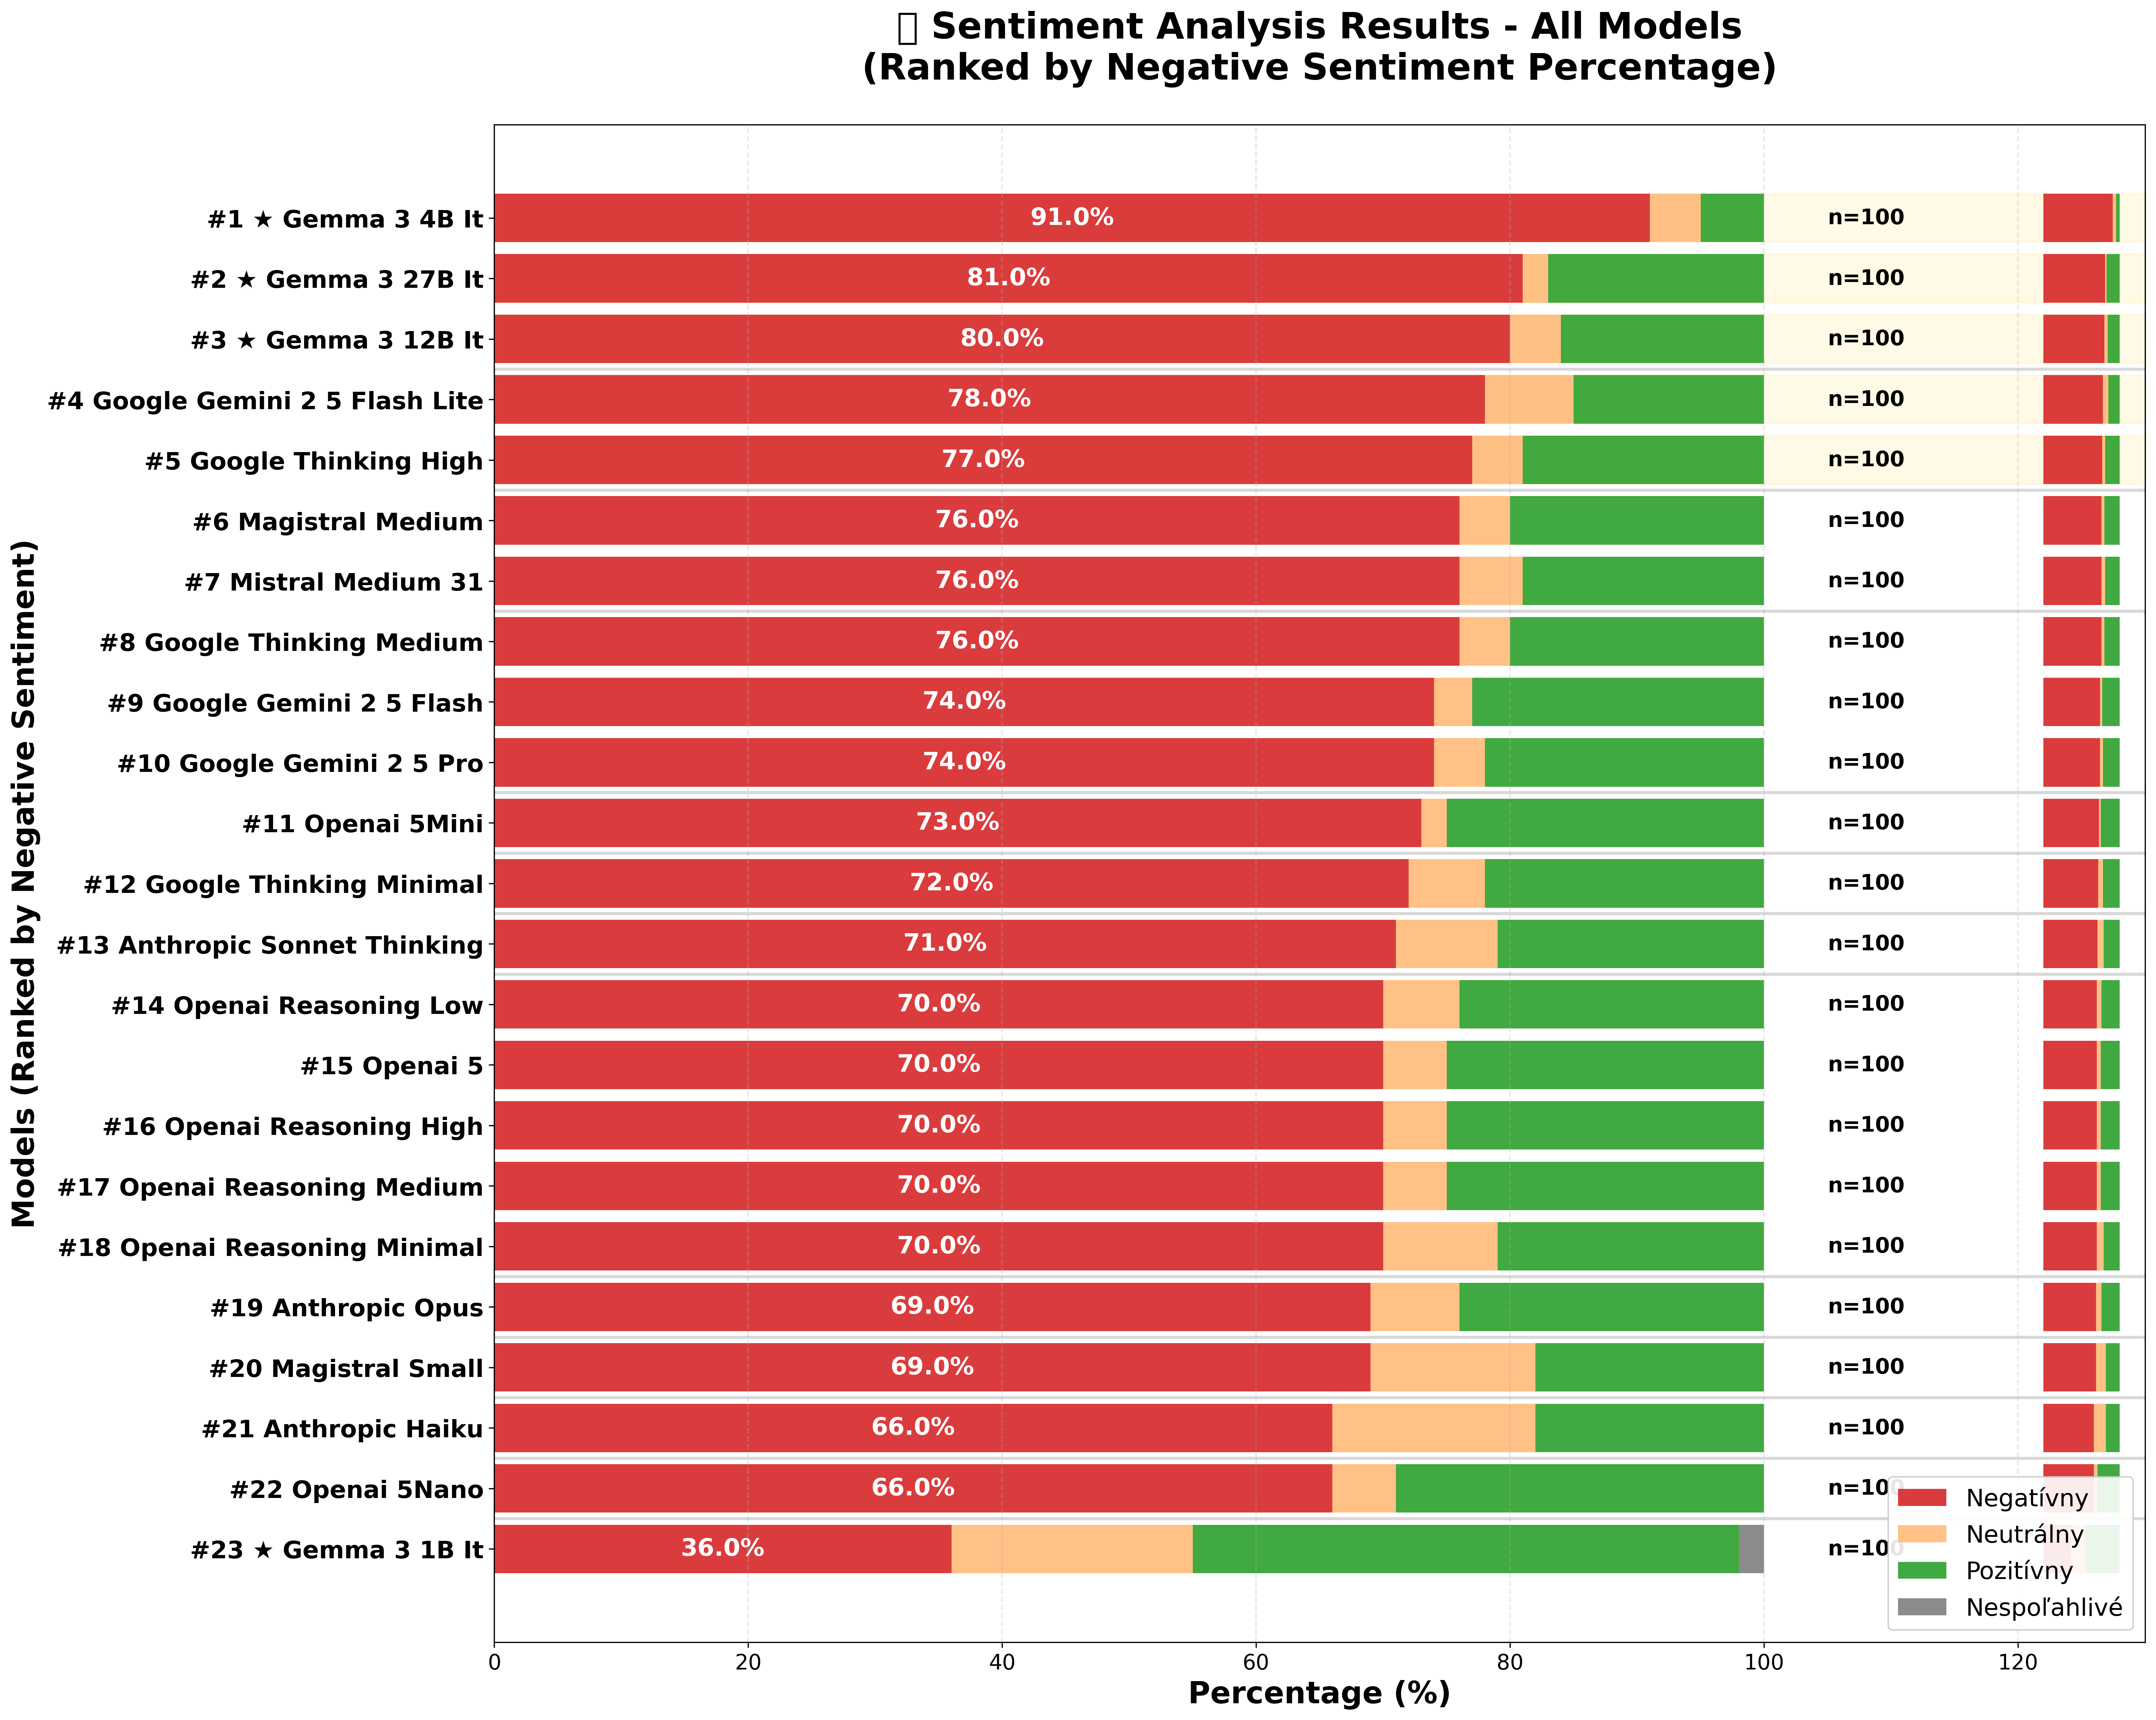


🎨 HIGH-RESOLUTION HORIZONTAL CHART COMPLETED!
📊 Features:
   ✅ ALL 23 models included
   📏 Figure size: 20 x 16 inches
   🔍 High resolution: 600 DPI
   📝 Enhanced font sizes (16pt model names, 16pt+ percentages)
   ⭐ Gemma models marked with stars
   🏆 Top 5 models highlighted with golden background
   📊 Reliability scores shown for problematic models
   📊 Proportion bar on right shows sentiment distribution by color

💾 SAVED IN MULTIPLE HIGH-RESOLUTION FORMATS:
   📄 PNG (600 DPI): sentiment_all_models_horizontal_HR_20250906_174851.png
   📄 PDF (600 DPI): sentiment_all_models_horizontal_HR_20250906_174851.pdf
   📄 SVG (Vector): sentiment_all_models_horizontal_HR_20250906_174851.svg

📐 CHART SPECIFICATIONS:
   📊 Chart dimensions: 20" × 16"
   🔤 Model names: 16pt bold font
   📈 Percentages: 14-16pt bold font
   📊 Total models displayed: 23
   🎯 Ranking: #1 (top) to #23 (bottom)


In [65]:
# =========================================================
# 🎨 HIGH-RESOLUTION HORIZONTAL CHART - ALL MODELS (Proportion Bar on Right)
# =========================================================

# Set up high-resolution matplotlib parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

num_models = len(updated_sentiment_df)
fig_height = max(16, num_models * 0.6)

fig, ax = plt.subplots(figsize=(20, fig_height))

y_positions_all = range(len(updated_sentiment_df))
models_all = updated_sentiment_df['model'].tolist()
negative_all = updated_sentiment_df['negative_pct'].tolist()
neutral_all = updated_sentiment_df['neutral_pct'].tolist()
positive_all = updated_sentiment_df['positive_pct'].tolist()
unreliable_all = updated_sentiment_df['unreliable_pct'].tolist()

# Main horizontal stacked bars (left side)
bars1_all = ax.barh(y_positions_all, negative_all, label='Negatívny', 
                    color=updated_colors['negative'], alpha=0.9, height=0.8)
bars2_all = ax.barh(y_positions_all, neutral_all, left=negative_all, 
                    label='Neutrálny', color=updated_colors['neutral'], alpha=0.9, height=0.8)
positive_left_all = [neg + neu for neg, neu in zip(negative_all, neutral_all)]
bars3_all = ax.barh(y_positions_all, positive_all, left=positive_left_all,
                    label='Pozitívny', color=updated_colors['positive'], alpha=0.9, height=0.8)
unreliable_left_all = [neg + neu + pos for neg, neu, pos in zip(negative_all, neutral_all, positive_all)]
bars4_all = ax.barh(y_positions_all, unreliable_all, left=unreliable_left_all,
                    label='Nespoľahlivé', color=updated_colors['unreliable'], alpha=0.9, height=0.8)

# Proportion bar on the right (color-coded)
for i in y_positions_all:
    proportions = [
        negative_all[i] / 100,
        neutral_all[i] / 100,
        positive_all[i] / 100,
        unreliable_all[i] / 100
    ]
    left = 122  # Start position for proportion bar (right of main bars)
    width = 6   # Width of the proportion bar
    colors = [
        updated_colors['negative'],
        updated_colors['neutral'],
        updated_colors['positive'],
        updated_colors['unreliable']
    ]
    start = left
    for prop, color in zip(proportions, colors):
        ax.barh(i, width * prop, left=start, height=0.8, color=color, alpha=0.9)
        start += width * prop

# Chart customization
ax.set_title('📊 Sentiment Analysis Results - All Models\n(Ranked by Negative Sentiment Percentage)', 
             fontsize=24, fontweight='bold', pad=30)
ax.set_xlabel('Percentage (%)', fontsize=20, fontweight='bold')
ax.set_ylabel('Models (Ranked by Negative Sentiment)', fontsize=20, fontweight='bold')
ax.set_xlim(0, 130)
ax.set_yticks(y_positions_all)

enhanced_model_names = []
for i, (model, is_gemma) in enumerate(zip(models_all, updated_sentiment_df['is_gemma'])):
    rank = i + 1
    if is_gemma:
        enhanced_model_names.append(f"#{rank} ★ {model}")
    else:
        enhanced_model_names.append(f"#{rank} {model}")

ax.set_yticklabels(enhanced_model_names, fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
ax.legend(loc='lower right', fontsize=16, framealpha=0.9)

# Labels and annotations
for i, (neg_pct, total_valid, is_gemma, unreliable_pct) in enumerate(
    zip(negative_all, updated_sentiment_df['total_valid'], 
        updated_sentiment_df['is_gemma'], unreliable_all)):
    if neg_pct > 10:
        ax.text(neg_pct/2, i, f'{neg_pct:.1f}%', ha='center', va='center', fontweight='bold', color='white', fontsize=16)
    elif neg_pct > 5:
        ax.text(neg_pct/2, i, f'{neg_pct:.1f}%', ha='center', va='center', fontweight='bold', color='white', fontsize=14)
    ax.text(105, i, f'n={total_valid}', ha='left', va='center', fontsize=14, color='black', fontweight='bold')
    if is_gemma and unreliable_pct > 5:
        ax.text(110, i, f'⚠️ {unreliable_pct:.0f}%', ha='left', va='center', fontsize=12, color='red', fontweight='bold')
        reliability_score = 100 - unreliable_pct
        if reliability_score < 95:
            ax.text(115, i, f'R:{reliability_score:.0f}%', ha='left', va='center', fontsize=10, color='orange', fontweight='bold')

ax.invert_yaxis()

for i in range(min(5, len(y_positions_all))):
    ax.axhspan(i-0.4, i+0.4, alpha=0.1, color='gold', zorder=0)

model_type_changes = []
current_type = None
for i, model in enumerate(models_all):
    model_lower = model.lower()
    if 'openai' in model_lower or 'gpt' in model_lower:
        model_type = 'OpenAI'
    elif 'anthropic' in model_lower or 'claude' in model_lower:
        model_type = 'Anthropic'
    elif 'google' in model_lower or 'gemini' in model_lower:
        model_type = 'Google'
    elif 'mistral' in model_lower or 'magistral' in model_lower:
        model_type = 'Mistral'
    elif 'gemma' in model_lower:
        model_type = 'Gemma'
    else:
        model_type = 'Other'
    if current_type and current_type != model_type:
        model_type_changes.append(i)
    current_type = model_type

for change_point in model_type_changes:
    ax.axhspan(change_point-0.5, change_point-0.5, color='gray', alpha=0.3, linewidth=2)

plt.tight_layout()

hr_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f'../graphs/sentiment_all_models_horizontal_HR_{hr_timestamp}.png', 
            dpi=600, bbox_inches='tight', facecolor='white', edgecolor='none',
            metadata={'Title': 'Sentiment Analysis - All Models Horizontal View'})
plt.savefig(f'../graphs/sentiment_all_models_horizontal_HR_{hr_timestamp}.pdf', 
            dpi=600, bbox_inches='tight', facecolor='white', edgecolor='none',
            metadata={'Title': 'Sentiment Analysis - All Models Horizontal View'})
plt.savefig(f'../graphs/sentiment_all_models_horizontal_HR_{hr_timestamp}.svg', 
            bbox_inches='tight', facecolor='white', edgecolor='none',
            metadata={'Title': 'Sentiment Analysis - All Models Horizontal View'})

plt.show()
plt.rcParams.update(plt.rcParamsDefault)

print(f"\n🎨 HIGH-RESOLUTION HORIZONTAL CHART COMPLETED!")
print(f"📊 Features:")
print(f"   ✅ ALL {num_models} models included")
print(f"   📏 Figure size: 20 x {fig_height} inches")
print(f"   🔍 High resolution: 600 DPI")
print(f"   📝 Enhanced font sizes (16pt model names, 16pt+ percentages)")
print(f"   ⭐ Gemma models marked with stars")
print(f"   🏆 Top 5 models highlighted with golden background")
print(f"   📊 Reliability scores shown for problematic models")
print(f"   📊 Proportion bar on right shows sentiment distribution by color")

print(f"\n💾 SAVED IN MULTIPLE HIGH-RESOLUTION FORMATS:")
print(f"   📄 PNG (600 DPI): sentiment_all_models_horizontal_HR_{hr_timestamp}.png")
print(f"   📄 PDF (600 DPI): sentiment_all_models_horizontal_HR_{hr_timestamp}.pdf")
print(f"   📄 SVG (Vector): sentiment_all_models_horizontal_HR_{hr_timestamp}.svg")

print(f"\n📐 CHART SPECIFICATIONS:")
print(f"   📊 Chart dimensions: 20\" × {fig_height}\"")
print(f"   🔤 Model names: 16pt bold font") 
print(f"   📈 Percentages: 14-16pt bold font")
print(f"   📊 Total models displayed: {num_models}")
print(f"   🎯 Ranking: #1 (top) to #{num_models} (bottom)")

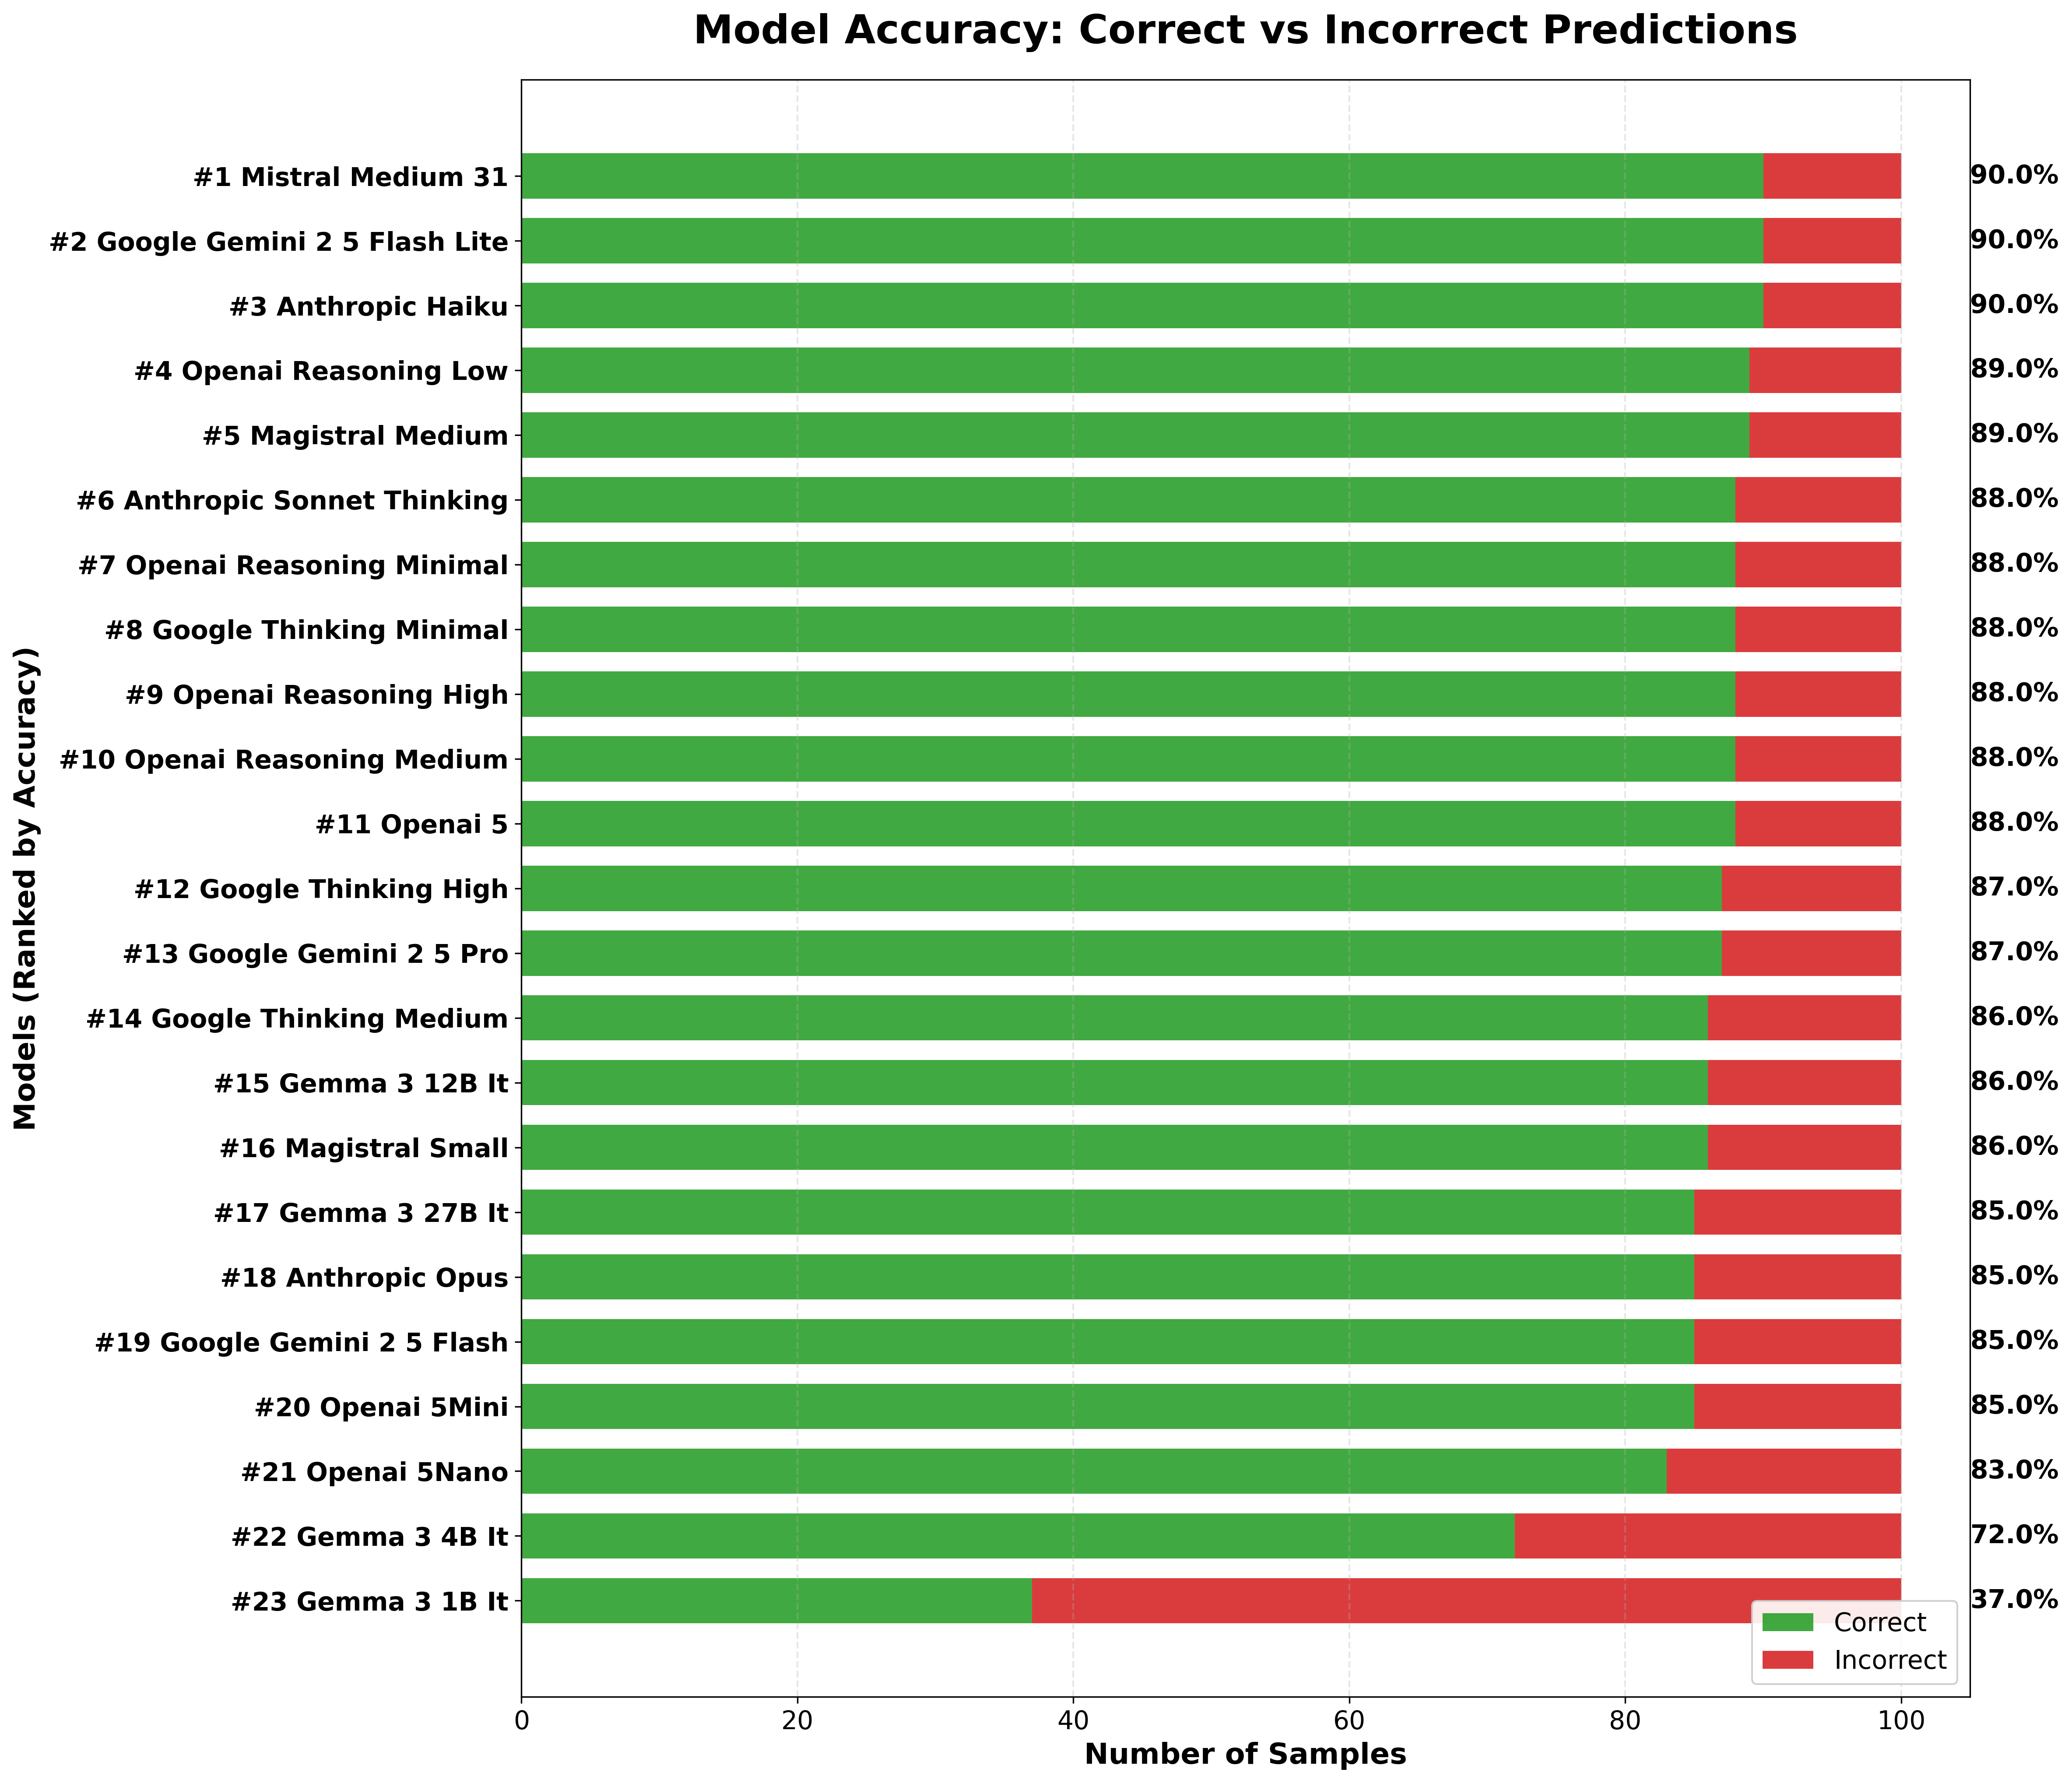

In [66]:
# =========================================================
# 🎨 HORIZONTAL BAR CHART RANKED BY ACCURACY (Correct vs Incorrect)
# =========================================================

import matplotlib.pyplot as plt
from datetime import datetime

# Calculate accuracy and prepare data
accuracy_data = []
for col in [c for c in df_results.columns if c.startswith('sentiment_')]:
    if col not in df_results.columns or 'label' not in df_results.columns:
        continue
    valid_mask = df_results[col].notna() & df_results['label'].notna()
    valid = df_results[valid_mask]
    if len(valid) == 0:
        continue
    correct = (valid[col] == valid['label']).sum()
    incorrect = len(valid) - correct
    accuracy = correct / len(valid)
    accuracy_data.append({
        'Model': col.replace('sentiment_', '').replace('_', ' ').title(),
        'Correct': correct,
        'Incorrect': incorrect,
        'Accuracy': accuracy,
        'Total': len(valid)
    })

accuracy_df = pd.DataFrame(accuracy_data).sort_values('Accuracy', ascending=False).reset_index(drop=True)

# Plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

num_models = len(accuracy_df)
fig_height = max(12, num_models * 0.6)
fig, ax = plt.subplots(figsize=(16, fig_height))

y_positions = range(num_models)
models = accuracy_df['Model'].tolist()
correct = accuracy_df['Correct'].tolist()
incorrect = accuracy_df['Incorrect'].tolist()

# Stacked horizontal bars: correct (green), incorrect (red)
bars_correct = ax.barh(y_positions, correct, label='Correct', color='#2ca02c', alpha=0.9, height=0.7)
bars_incorrect = ax.barh(y_positions, incorrect, left=correct, label='Incorrect', color='#d62728', alpha=0.9, height=0.7)

ax.set_title('Model Accuracy: Correct vs Incorrect Predictions', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Number of Samples', fontsize=16, fontweight='bold')
ax.set_ylabel('Models (Ranked by Accuracy)', fontsize=16, fontweight='bold')
ax.set_yticks(y_positions)
ax.set_yticklabels([f"#{i+1} {m}" for i, m in enumerate(models)], fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
ax.legend(loc='lower right', fontsize=14, framealpha=0.9)
ax.invert_yaxis()

# Annotate accuracy percentage on bars
for i, (acc, tot) in enumerate(zip(accuracy_df['Accuracy'], accuracy_df['Total'])):
    ax.text(tot + 5, i, f"{acc*100:.1f}%", va='center', ha='left', fontsize=14, fontweight='bold', color='black')

plt.tight_layout()
hr_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f'../graphs/model_accuracy_horizontal_{hr_timestamp}.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
